Travail réalisé par **Bastien AVRILLON et Jérémie BRAILLON**

# -------------------------------------------------------------
# Introduction au notebook
# -------------------------------------------------------------
Bienvenue dans le défi Données Réelles ! Ce notebook est conçu pour vous apprendre à manipuler, nettoyer et analyser des données environnementales réelles, puis à les utiliser dans un modèle physique.

**Objectifs pédagogiques :**
- Comprendre les étapes de préparation et de nettoyage des données.
- Apprendre à synchroniser et traiter des mesures issues de capteurs.
- Découvrir les méthodes d’identification et de suppression des valeurs aberrantes.
- Utiliser les données pour calibrer et simuler un modèle physique (pyheatmy).
- Interpréter les résultats et discuter l’impact du traitement des données.

**Contexte :**
Vous allez travailler sur des données de température et de pression mesurées dans une rivière. Ces données sont issues de capteurs et nécessitent un traitement avant d’être utilisées dans un modèle.

**Structure du notebook :**
1. Chargement et exploration des données
2. Nettoyage et synchronisation des mesures
3. Analyse statistique et détection des valeurs aberrantes
4. Préparation des données pour le modèle
5. Simulation et inversion avec pyheatmy
6. Discussion et interprétation des résultats

**Conseils pour réussir :**
- Lisez attentivement les consignes et les commentaires.
- Exécutez chaque cellule dans l’ordre et vérifiez les sorties.
- N’hésitez pas à commenter votre code et à poser des questions.
- Les cellules marquées "À vous de jouer !" sont des exercices pour vous entraîner.

**Ressources à disposition :**
* infos_point="./MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/point35_info.txt"
* Schema="./MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/point35_schema.png"
* chemin_capteur_riviere = "./MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/p_point035_measures.csv"
* chemin_capteur_ZH = "./MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/t_point035_T_measures.csv"
* chemin_etalonage_capteur_riv = "./MOLONARI_1D_RESOURCES/configuration/pressure_sensors/P508.csv"

> **À vous de jouer !** Tout au long de ce notebook, vous trouverez des cellules (code ou texte) marquées "À vous de jouer !". Ce sont des exercices pour vous aider à comprendre les concepts abordés. Une fois votre code écrit, exécutez la cellule en cliquant dedans puis en appuyant sur CTRL + ENTER (CMD + ENTER sur Mac). Vous pouvez aussi cliquer sur la flèche "play" à gauche de la cellule. Pour exécuter tout le notebook, utilisez les doubles flèches "avance rapide" en bas de l'éditeur.

Voici le programme du jour :
* Vérifier le type de données de la colonne date
* Convertir les colonnes de date en datetime
* Afficher le jour du mois pour vérifier le parsing des dates
* Nettoyer et synchroniser les données
* Détecter et traiter les valeurs aberrantes
* Simuler et inverser le modèle physique
* Interpréter et discuter les résultats

In [2]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats


# Définir ZERO_CELSIUS (conversion Celsius vers Kelvin)
ZERO_CELSIUS = 273.15


# 1. Premier aperçu des données du Point 35
________

**Objectif de cette section :** Charger et explorer les données environnementales réelles du point de mesure 35.

Dans cette première étape, nous allons :
- Définir les chemins d'accès aux fichiers de données
- Charger les données de température et de pression
- Examiner la structure des fichiers
- Visualiser le schéma expérimental du point de mesure

**Données disponibles :**
- **Fichier de pression :** Mesures de tension (en volts) et température de la rivière
- **Fichier de température :** Mesures de température à 4 profondeurs dans le sédiment
- **Fichier de géométrie :** Configuration du point de mesure et profondeurs des capteurs
- **Fichier d'étalonnage :** Coefficients de conversion tension/pression pour le capteur

> **⚠️ Important !** Exécutez la cellule de code suivante pour que le reste du notebook fonctionne correctement. Les librairies et les constantes définies sont essentielles pour la suite.

In [3]:
# define the folder path
folder = 'D:/Cours Mines de Paris/TI Molonari/MOLONARI1D/dataAnalysis/'

# read in our data
path_files = folder + 'raw_data/'
path_config= folder + 'configuration/pressure_sensors/'
contenuDossier = os.listdir(path_files)
print(contenuDossier)

['.DS_Store', 'point13_29_07_15', 'point14_29_07_15', 'point15_29_07_15', 'point34_27_06_16', 'point35_07_12_16', 'point36_12_07_16', 'point46_17_06_19', 'point47_27_08_19', 'point48_14_04_18', 'point52_13_10_23', 'point53_13_10_23', 'schema_dispositif_AvAv_23_07_15.png']


## 1.1 Visualisation du schéma expérimental

Le schéma ci-dessous montre la configuration du point de mesure 35. Il illustre :

- **La tige de mesure** enfoncée dans le sédiment de la rivière
- **Les capteurs de température** positionnés à différentes profondeurs (10, 20, 30, 40 cm)
- **Le capteur de pression** qui mesure les variations de niveau d'eau
- **L'interface eau-sédiment** où se produisent les échanges thermiques

> **🔍 À observer :** Notez la position relative des capteurs et la géométrie du dispositif expérimental. Cette configuration permet de mesurer les gradients de température verticaux dans le sédiment ainsi que la difference de pression entre la rivière et le bas de la colonne.

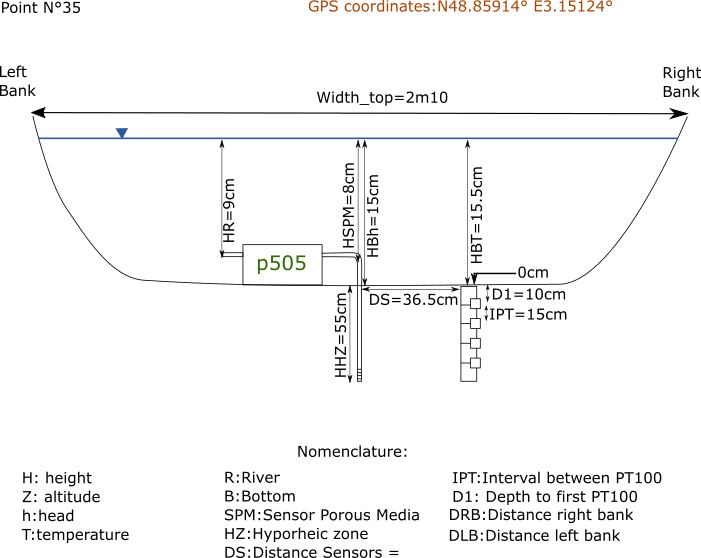

In [4]:

point='point35_07_12_16/'
# le chemin vers le dossier
chemin = path_files + point
# Spécifiez le chemin de votre fichier PNG
chemin_image = chemin + point.split('_')[0] + '_schema.png'

# Affichez l'image dans le notebook
Image(filename=chemin_image)

## 1.2 Chargement automatique des données

Dans cette section, nous allons charger les données du point de mesure 35 en utilisant des fonctions automatisées :

### Fonctions de lecture de fichiers
- **`read_csv()`** : Détecte automatiquement le séparateur des fichiers CSV et gère les en-têtes
- **Lecture de la géométrie** : Extraction des informations de configuration depuis `geometrie.txt`
- **Lecture des coefficients d'étalonnage** : Chargement des paramètres de calibration du capteur

### Données collectées
Le code ci-dessous va automatiquement :
1. **Identifier le capteur** utilisé (P508)
2. **Charger les mesures de pression** (tension en volts + température rivière)
3. **Charger les mesures de température** (4 profondeurs dans le sédiment)
4. **Récupérer les coefficients d'étalonnage** pour convertir la tension en pression

> **📝 Note :** Cette approche automatisée facilite le traitement de plusieurs points de mesure avec la même structure de données.

In [5]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

## 1.3 Résumé des données chargées

Après le chargement automatique, vérifions les informations collectées pour le point de mesure 35 :

### Informations techniques récupérées
- **Capteur utilisé** : Identifiant du capteur de pression
- **Profondeurs de mesure** : Positions des capteurs de température dans le sédiment
- **Coefficients d'étalonnage** : Paramètres de conversion tension → pression

### Structure des données
Le dictionnaire `dico` contient maintenant :
- `dico['capteur']` : Type de capteur utilisé
- `dico['pression']` : DataFrame avec mesures de pression/tension
- `dico['temperature']` : DataFrame avec mesures de température multi-profondeurs
- `dico['intercept']`, `dico['dU/dH']`, `dico['dU/dT']` : Coefficients d'étalonnage

> **💡 Astuce :** Ces informations seront essentielles pour la conversion des données brutes en unités physiques (volts → mètres de colonne d'eau).

In [6]:

# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
dico = {}
# le chemin vers le dossier
dico['chemin'] = path_files + point

with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
    lignes = fichier.readlines()
    # le nom du capteur
    dico['capteur'] = lignes[1][:4]
    # la profondeur du capteur
    if lignes[3] == '\n' :
        dico['profondeur'] = 0
    else : 
        dico['profondeur'] = lignes[3]
        # les profondeurs auxquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))


    # on va ensuite mettre les dataframes dans le dictionnaire
contenuDossierPoint = os.listdir(dico['chemin'])
for x in contenuDossierPoint:
    # la pression
    if x.startswith('p') and x.endswith('.csv'):
        dico['pression'] = read_csv(dico['chemin'] + '/' + x)
    # la température
    if x.startswith('t') and x.endswith('.csv'):
        dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
with open(path_config + dico['capteur'].upper() + '.csv') as fichier:
    lignes = fichier.readlines()
    for l in lignes:
        if l.startswith('Intercept'):
            dico['intercept'] = float(l[10:-2])
        if l.startswith('dU/dH'):
            dico['dU/dH'] = float(l[6:-2])
        if l.startswith('dU/dT'):
            dico['dU/dT'] = float(l[6:-2]) 



## 1.4 Inspection et renommage des colonnes

Maintenant que nos données sont chargées, examinons la structure des DataFrames et renommons les colonnes pour plus de clarté.

**Objectif :** Standardiser les noms de colonnes pour faciliter l'analyse.

### Colonnes à renommer :
- **Fichier pression :** `dates`, `tension_V`, `temperature_stream_C`
- **Fichier température :** `dates`, `temperature_depth_1_C`, `temperature_depth_2_C`, `temperature_depth_3_C`, `temperature_depth_4_C`

> **📋 À faire :** Vérifiez d'abord le contenu actuel des colonnes, puis procédez au renommage.





In [7]:
# Vérifier d'abord le nombre de colonnes dans chaque DataFrame
print("Colonnes température:", len(dico['temperature'].columns))
print("Colonnes pression:", len(dico['pression'].columns))
print("Colonnes température:", dico['temperature'].columns.tolist())
print("Colonnes pression:", dico['pression'].columns.tolist())

Colonnes température: 5
Colonnes pression: 3
Colonnes température: ['Date Heure, GMT+01:00', 'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164)', 'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).1', 'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).2', 'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).3']
Colonnes pression: ['Date Heure, GMT+01:00', 'Tension, V (LGR S/N: 10445475, SEN S/N: 10445475, LBL: température)', 'Temp., °C (LGR S/N: 10445475, SEN S/N: 10445475, LBL: Température)']


### a) Aperçu des données du capteur de pression dans la rivière

**Contenu :** Mesures de tension (en volts) représentant la différence de pression et température de la rivière.

**Variables importantes :**
- `tension_V` : Signal électrique du capteur de pression (à convertir en mètres)
- `temperature_stream_C` : Température de l'eau de la rivière en degrés Celsius

In [8]:
# print the column name for file of temperature begin t and pressure begin p
print(dico['pression'].columns)

Index(['Date Heure, GMT+01:00',
       'Tension, V (LGR S/N: 10445475, SEN S/N: 10445475, LBL: température)',
       'Temp., °C (LGR S/N: 10445475, SEN S/N: 10445475, LBL: Température)'],
      dtype='object')


### b) Aperçu des données des capteurs de température dans le sédiment

**Contenu :** Mesures de température à 4 profondeurs différentes dans le sédiment de la rivière.

**Variables importantes :**
- `temperature_depth_1_C` : Température à 10 cm de profondeur (°C)
- `temperature_depth_2_C` : Température à 20 cm de profondeur (°C) 
- `temperature_depth_3_C` : Température à 30 cm de profondeur (°C)
- `temperature_depth_4_C` : Température à 40 cm de profondeur (°C)

In [9]:
# print the column name for file of temperature begin t and pressure begin p
print(dico['temperature'].columns)

Index(['Date Heure, GMT+01:00',
       'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164)',
       'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).1',
       'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).2',
       'Temp., °C (LGR S/N: 10117164, SEN S/N: 10117164).3'],
      dtype='object')


### c) Renommage des colonnes pour standardisation

**Action :** Application des nouveaux noms de colonnes standardisés aux DataFrames.

**Résultat :**
- Colonnes harmonisées et cohérentes entre les deux fichiers
- Noms explicites facilitant l'analyse et la manipulation des données
- Structure prête pour les étapes suivantes de traitement

> **✅ Vérification :** Après renommage, les données sont prêtes pour l'analyse des types de données et la conversion des dates.

In [10]:
# Renommez les colonnes en fonction de leur position
dico['temperature'].columns = [ 'dates', 'temperature_depth_1_C', 'temperature_depth_2_C', 'temperature_depth_3_C', 'temperature_depth_4_C']
dico['pression'].columns = [ 'dates', 'tension_V', 'temperature_stream_C']


## 2. Vérification du type de données des colonnes de dates
___

**Objectif :** S'assurer que Python reconnaît correctement les colonnes de dates comme des objets temporels.

Dans cette étape cruciale du traitement des données, nous allons :
- **Examiner les premières lignes** de la colonne dates pour vérifier visuellement son contenu
- **Analyser le type de données** assigné par pandas à cette colonne
- **Comprendre la différence** entre le type "object" et "datetime64"

> **⚠️ Point important :** Même si nous, humains, pouvons identifier visuellement des dates, Python doit être explicitement informé qu'une colonne contient des données temporelles pour pouvoir les manipuler correctement.


In [11]:
# print the first few rows of the date column
print(dico['temperature']['dates'].head())

0    07/12/16 11:00:00 AM
1    07/12/16 11:15:00 AM
2    07/12/16 11:30:00 AM
3    07/12/16 11:45:00 AM
4    07/12/16 12:00:00 PM
Name: dates, dtype: object


## 2.1 Analyse du type de données

Parfait, ces valeurs ressemblent bien à des dates ! Mais le fait que nous, humains, puissions identifier ces données comme des dates ne signifie pas que Python le sait.

**Observation importante :** Regardez attentivement la sortie de `head()` - au bas de l'affichage, vous pouvez voir que le type de données (dtype) de cette colonne est "object".

> **📚 Information pandas :** Pandas utilise le dtype "object" pour stocker différents types de données, mais le plus souvent, quand vous voyez une colonne avec le dtype "object", elle contient des chaînes de caractères (strings).

**Pourquoi c'est problématique ?** Si vous consultez la [documentation pandas des dtypes](http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes), vous remarquerez qu'il existe un dtype spécifique `datetime64` pour les données temporelles. 

**Diagnostic :** Puisque notre colonne a le dtype "object" plutôt que "datetime64", nous pouvons en déduire que Python ne reconnaît pas que cette colonne contient des dates.

**Vérification alternative :** Nous pouvons examiner uniquement le dtype de la colonne sans afficher les premières lignes :

In [12]:
# Vérifier le type de données de notre colonne de dates
dico['temperature']['dates'].dtype

dtype('O')

### Interprétation des codes de dtype

**Comprendre les codes numpy :** Il peut être nécessaire de consulter la [documentation numpy](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.dtype.kind.html#numpy.dtype.kind) pour faire correspondre le code de lettre au dtype de l'objet.

**Décodage :** "O" est le code pour "object", ce qui confirme que ces deux méthodes nous donnent la même information.

> **💡 À retenir :** Les deux approches (`head()` et `.dtype`) nous confirment que Python traite actuellement nos dates comme des chaînes de caractères plutôt que comme des objets temporels. Il faudra donc procéder à une conversion explicite.

## 2.2 Conversion des colonnes de dates en format datetime
___

**Objectif :** Convertir les chaînes de caractères en objets datetime pour permettre la manipulation temporelle.

Maintenant que nous savons que nos colonnes de dates ne sont pas reconnues comme des dates par Python, il est temps de les convertir pour qu'elles *soient* reconnues comme telles. Cette opération s'appelle "parsing de dates" car nous analysons une chaîne de caractères pour en identifier les composantes temporelles.

### Stratégie de conversion automatique

**Problématique :** Les données de terrain peuvent avoir des formats de date très variés selon les capteurs et les systèmes d'acquisition. Une fonction robuste doit pouvoir :

- **Tester plusieurs formats** couramment rencontrés dans les mesures environnementales
- **Valider l'ordre chronologique** des données converties
- **Gérer les échecs** de conversion avec des formats de secours

### Formats de dates supportés

La fonction `convertDates()` teste automatiquement une liste étendue de formats :

**Formats américains :** `%m/%d/%y`, `%m/%d/%Y` (mois/jour/année)  
**Formats européens :** `%d/%m/%y`, `%d/%m/%Y` (jour/mois/année)  
**Formats ISO :** `%Y/%m/%d` (année/mois/jour)  
**Avec heures :** Support des formats 12h et 24h, avec ou sans secondes

> **⚙️ Algorithme :** La fonction teste chaque format séquentiellement et valide que les timestamps résultants sont dans l'ordre chronologique, garantissant ainsi la cohérence temporelle des séries de mesures.  

In [13]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = dico['pression'][dico['pression'].columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

### Application de la conversion automatique

**Mise en pratique :** Nous allons maintenant appliquer la fonction `convertDates()` à nos deux DataFrames contenant les mesures de température et de pression.

**Processus de conversion :**
1. **Test séquentiel des formats** : La fonction essaie automatiquement chaque format de date
2. **Validation chronologique** : Vérification que l'ordre temporel est respecté
3. **Conversion en place** : Modification directe des DataFrames originaux

**Résultat attendu :** Après conversion, les colonnes `dates` passeront du type "object" au type "datetime64", permettant ainsi :
- Les opérations temporelles (extraction du jour, mois, année)
- Le tri chronologique automatique
- La création de graphiques temporels
- Les calculs d'intervalles de temps

> **🔄 Traitement automatique :** La fonction détecte automatiquement le bon format et applique la conversion sans intervention manuelle, garantissant la robustesse du traitement pour différents types de fichiers de mesures.

In [14]:
convertDates(dico['temperature'])
convertDates(dico['pression'])

## 2.3 Vérification de la conversion des dates par analyse des jours du mois
___

**Objectif :** Valider que la conversion des dates s'est effectuée correctement en analysant la distribution des jours.

L'un des plus grands risques lors du parsing de dates est la confusion entre les mois et les jours. Bien que la fonction `to_datetime()` fournisse des messages d'erreur utiles, il est prudent de vérifier que les jours du mois extraits sont cohérents.

### Méthode de validation

**Approche :** Nous allons créer un histogramme des jours du mois pour vérifier leur répartition.

**Résultats attendus :**
- **Valeurs entre 1 et 31** : Tous les jours doivent être dans cette plage
- **Distribution relativement uniforme** : Aucune raison que certains jours soient sur-représentés
- **Légère baisse au 31** : Tous les mois n'ont pas 31 jours

**Diagnostic :** Si la distribution présente des anomalies (pics inattendus, valeurs hors plage), cela peut indiquer une erreur de format de date.

> **🔍 Validation des données :** Cette vérification permet de détecter les erreurs de parsing qui pourraient passer inaperçues et compromettre l'analyse temporelle des séries de mesures.

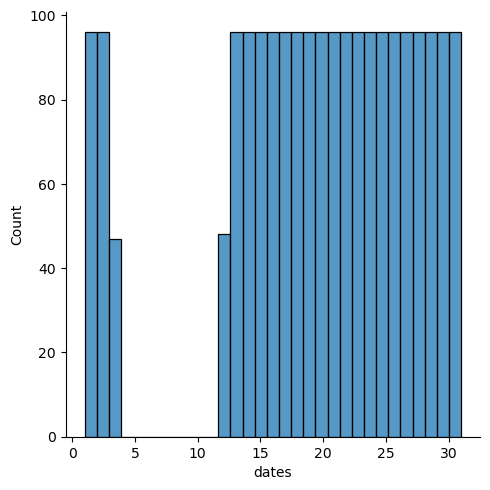

In [15]:
day_of_month_capteur_riviere = dico['temperature']['dates'].dt.day

# remove na's
day_of_month_capteur_riviere= day_of_month_capteur_riviere.dropna()

# plot the day of the month
sns.displot(day_of_month_capteur_riviere, kde=False, bins=31)

## 2.4 Visualisation des séries temporelles de température et de pression
___

**Objectif :** Créer des graphiques temporels pour visualiser l'évolution des mesures après conversion des dates.

Maintenant que nos dates sont correctement converties en objets datetime, nous pouvons créer des visualisations temporelles pour examiner les tendances et patterns dans nos données.

### Types de visualisations

**Graphiques à produire :**
1. **Série temporelle des températures** : Toutes les profondeurs + température de la rivière
2. **Série temporelle de la pression** : Signal de tension du capteur de pression

**Avantages de la visualisation temporelle :**
- **Détection de tendances** : Évolution saisonnière des températures
- **Identification d'anomalies** : Pics ou chutes inhabituels dans les données
- **Validation des mesures** : Cohérence entre les différents capteurs
- **Compréhension des cycles** : Variations journalières ou saisonnières

> **📊 Analyse visuelle :** Ces graphiques permettent une première évaluation qualitative des données avant les analyses statistiques plus poussées et servent de base pour identifier les périodes d'intérêt pour la modélisation.

In [16]:
dico['temperature'].head()

,dates,temperature_depth_1_C,temperature_depth_2_C,temperature_depth_3_C,temperature_depth_4_C
0,2016-07-12 12:00:00,22.154,21.604,20.317,20.650
1,2016-07-12 12:15:00,26.500,27.038,23.737,21.819
2,2016-07-12 12:30:00,14.553,13.738,13.690,13.738
3,2016-07-12 12:45:00,14.768,14.002,13.954,14.002
4,2016-07-12 13:00:00,15.031,14.649,14.816,15.079


In [17]:
dico['pression'].head()

,dates,tension_V,temperature_stream_C
0,2016-07-12 12:00:00,1.56471,20.007
1,2016-07-12 12:15:00,0.62210,14.361
2,2016-07-12 12:30:00,0.63614,14.314
3,2016-07-12 12:45:00,0.69780,14.218
4,2016-07-12 13:00:00,0.66911,14.098


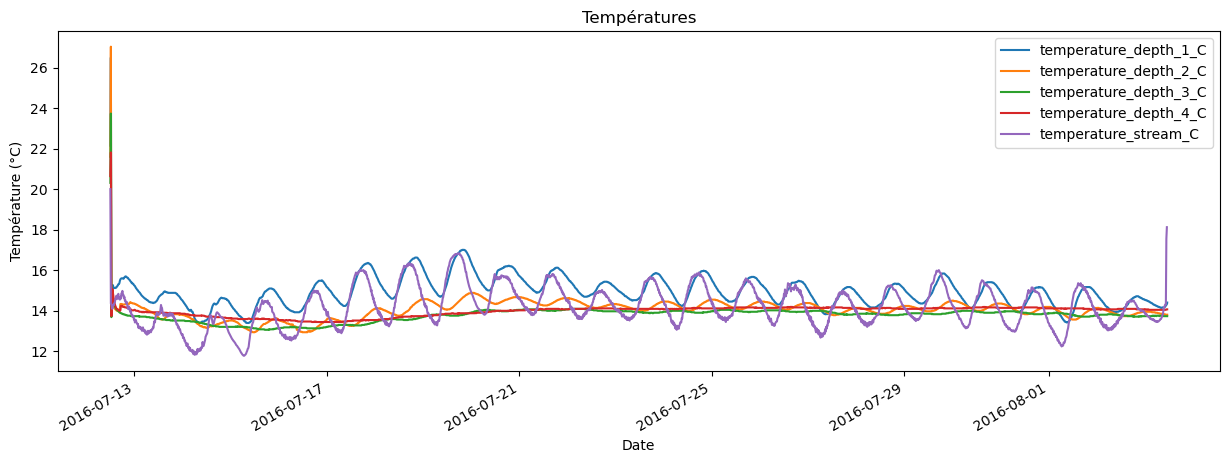

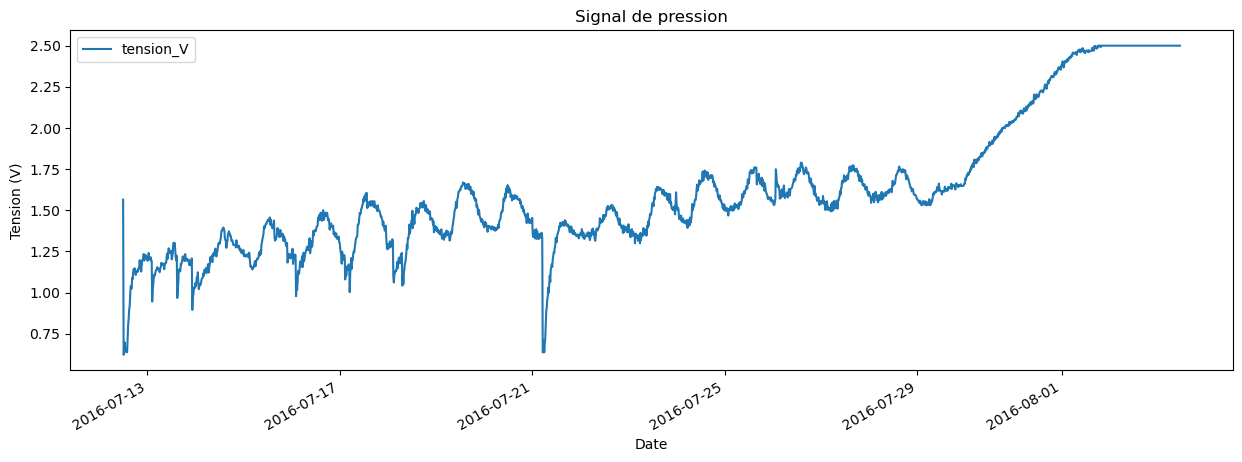

In [18]:
# Tracer toutes les températures (profondeurs 1-4) et les données de pression brutes (tension et température)

fig, ax = plt.subplots(figsize=(15, 5))

dico['temperature'].plot(x='dates', y=['temperature_depth_1_C', 'temperature_depth_2_C', 'temperature_depth_3_C', 'temperature_depth_4_C'], ax=ax)
dico['pression'].plot(x='dates', y='temperature_stream_C', ax=ax)

plt.title('Températures')
plt.xlabel('Date')
plt.ylabel('Température (°C)')

plt.show()


# Pression en volts
fig, ax = plt.subplots(figsize=(15, 5))
dico['pression'].plot(x='dates', y='tension_V', ax=ax)
plt.title('Signal de pression')
plt.xlabel('Date')
plt.ylabel('Tension (V)')
plt.show()


# 3. supprimer les NA
___



In [19]:
dico['temperature'] = dico['temperature'].dropna(axis = 0, how = 'any')
dico['pression'] = dico['pression'].dropna(axis = 0, how='any')

# 4. Conversion des données de tension en différence de charge hydraulique
___

**Objectif :** Transformer les mesures de tension électrique du capteur de pression en valeurs physiques de différence de charge hydraulique (en mètres).

### Principe de la conversion

Les capteurs de pression piézorésistifs génèrent un signal électrique (tension en volts) proportionnel à la pression appliquée. Pour obtenir des valeurs physiques exploitables, nous devons appliquer une calibration qui tient compte :

**Variables d'étalonnage disponibles :**
- **k₀ (intercept)** : Tension de référence à pression nulle
- **k₁ (dU/dH)** : Sensibilité du capteur (V/m de colonne d'eau)
- **k₂ (dU/dT)** : Correction thermique (V/°C)

### Formule de conversion

La différence de charge hydraulique (dH) est calculée selon la relation d'étalonnage :

**dH = (1/k₁) × (U - k₀ - k₂ × T)**

Où :
- **U** : Tension mesurée par le capteur (V)
- **T** : Température de la rivière (°C)
- **dH** : Différence de charge hydraulique (m)

### Correction de température

La correction thermique **k₂ × T** est essentielle car :
- Les composants électroniques dérivent avec la température
- La viscosité de l'eau change avec la température
- Les propriétés du matériau piézorésistif varient thermiquement

> **⚙️ Ingénierie des capteurs :** Cette calibration multi-paramètres garantit la précision des mesures dans des conditions environnementales variables, aspect crucial pour les études hydrogéologiques quantitatives.

In [20]:

# Extraction des coefficients d'étalonnage
k0 = float(dico['intercept'])
k1 = float(dico['dU/dH'])
k2 = float(dico['dU/dT'])

# Affichage des coefficients d'étalonnage
print("=== Coefficients d'étalonnage du capteur ===")
print(f"k₀ (intercept) = {k0:.5f} V")
print(f"k₁ (sensibilité) = {k1:.5f} V/m")
print(f"k₂ (correction thermique) = {k2:.5f} V/°C")
print()

# Préparation des données pour le calcul
U = dico['pression']['tension_V'].astype(float)
T = dico['pression']['temperature_stream_C'].astype(float)

# Calcul de la différence de charge hydraulique avec correction
# Formule: dH = (1/k₁) × (U - k₀ - k₂ × T)
dico['pression'].loc[:, 'dH'] = (1 / k1) * (U - k0 - k2 * T)

# Affichage des statistiques de la conversion
print("=== Résultats de la conversion ===")
print(f"Nombre de mesures converties: {len(dico['pression'])}")
print(f"Plage de dH: {dico['pression']['dH'].min():.3f} à {dico['pression']['dH'].max():.3f} m")
print(f"Moyenne de dH: {dico['pression']['dH'].mean():.3f} m")
print(f"Écart-type de dH: {dico['pression']['dH'].std():.3f} m")



=== Coefficients d'étalonnage du capteur ===
k₀ (intercept) = 1.21034 V
k₁ (sensibilité) = -1.46249 V/m
k₂ (correction thermique) = 0.00147 V/°C

=== Résultats de la conversion ===
Nombre de mesures converties: 2109
Plage de dH: -0.868 à 0.417 m
Moyenne de dH: -0.258 m
Écart-type de dH: 0.275 m


C:\Users\marti\AppData\Local\Temp\ipykernel_16920\3735446582.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dico['pression'].loc[:, 'dH'] = (1 / k1) * (U - k0 - k2 * T)


In [21]:
dico['pression']

,dates,tension_V,temperature_stream_C,dH
0,2016-07-12 12:00:00,1.56471,20.007,-0.222196
1,2016-07-12 12:15:00,0.62210,14.361,0.416653
2,2016-07-12 12:30:00,0.63614,14.314,0.407006
3,2016-07-12 12:45:00,0.69780,14.218,0.364748
4,2016-07-12 13:00:00,0.66911,14.098,0.384245
...,...,...,...,...
2104,2016-08-03 10:00:00,2.49939,14.266,-0.867068
2105,2016-08-03 10:15:00,2.49939,14.314,-0.867020
2106,2016-08-03 10:30:00,2.49939,14.314,-0.867020
2107,2016-08-03 10:45:00,2.49939,17.558,-0.863760


# 5. Détection et traitement des valeurs aberrantes
___

**Objectif :** Identifier et éliminer les observations anormales qui pourraient compromettre la qualité de l'analyse et de la modélisation.

## Problématique des valeurs aberrantes

Les valeurs aberrantes représentent l'un des défis majeurs du nettoyage des données environnementales. Ces observations, significativement différentes du comportement normal des capteurs, peuvent provenir de :

**Sources d'erreurs courantes :**
- **Dysfonctionnements des capteurs** : Dérive électronique, encrassement, chocs mécaniques
- **Conditions environnementales extrêmes** : Crues, gel, obstruction des sondes
- **Erreurs de transmission** : Perturbations électromagnétiques, défauts de communication
- **Problèmes d'acquisition** : Conflits logiciels, erreurs d'horodatage

**Impact sur la modélisation :**
- **Biais des paramètres** : Les algorithmes d'estimation deviennent moins performants
- **Convergence altérée** : Les méthodes d'inversion peuvent échouer ou donner des résultats erronés
- **Interprétation faussée** : Les conclusions scientifiques peuvent être compromises

## Stratégie d'analyse

**Démarche systématique :**
1. **Analyse statistique descriptive** : Examen des distributions avec `describe()`
2. **Détection par méthode IQR** : Identification basée sur les quartiles
3. **Détection par Z-score** : Identification basée sur les écarts-types
4. **Visualisation comparative** : Graphiques avant/après nettoyage


> **🎯 Objectif qualité :** Obtenir des séries temporelles robustes et fiables pour alimenter le modèle pyheatmy avec des données de haute qualité, essentielles pour des inversions hydrothermiques précises.


In [22]:
dico['pression'][["dH","temperature_stream_C"]].describe()

,dH,temperature_stream_C
count,2109.000000,2109.000000
mean,-0.258097,14.204242
std,0.275431,0.992300
min,-0.868301,11.783000
25%,-0.323564,13.546000
50%,-0.206443,14.098000
75%,-0.083631,14.912000
max,0.416653,20.007000


Voici ce que chaque statistique signifie :
* std (écart type) : L'écart type mesure la dispersion des valeurs par rapport à la moyenne. Plus l'écart type est élevé, plus les valeurs sont dispersées autour de la moyenne. C'est une mesure de la variabilité des données. Un écart type faible indique que les valeurs sont regroupées autour de la moyenne.

* min (valeur minimale) : C'est la plus petite valeur dans la colonne. Cela vous montre la valeur la plus basse que la colonne prend.

* 25%, 50%, 75% (quartiles) : Ces valeurs correspondent aux quartiles de la distribution des données. Le 25e percentile est le point en dessous duquel se trouve le 25 % des valeurs, le 50e percentile est la médiane (la valeur qui sépare la distribution en deux moitiés égales), et le 75e percentile est le point en dessous duquel se trouve le 75 % des valeurs.
* max (valeur maximale) : C'est la plus grande valeur dans la colonne. Cela vous montre la valeur la plus élevée que la colonne prend.

En utilisant describe(), vous obtenez donc un aperçu complet de la distribution des données dans ces deux colonnes, ce qui peut vous aider à comprendre rapidement les tendances, les valeurs extrêmes et la variabilité des données. C'est un outil très utile pour explorer et comprendre vos données.

## 5.1 Application pratique : nettoyage des données de pression
___
**Objectif :** Créer une version nettoyée du DataFrame de pression en appliquant la méthode IQR aux variables pertinentes.

### Étapes de traitement

Dans cette section, nous allons systématiquement nettoyer les données de pression en :

1. **Création d'une copie de sauvegarde** : Conservation des données originales
2. **Sélection des variables à traiter** : Identification des colonnes numériques à nettoyer
3. **Application de la méthode IQR** : Suppression itérative des valeurs aberrantes
4. **Validation des résultats** : Comparaison visuelle avant/après traitement

### Variables concernées

**Colonnes à traiter :**
- `dH` : Différence de charge hydraulique (variable principale)
- `temperature_stream_C` : Température de la rivière

**Colonnes à préserver :**
- `dates` : Horodatage des mesures (référence temporelle)
- `tension_V` : Signal brut du capteur (pour traçabilité)

### Méthode de nettoyage

**Processus itératif :** Pour chaque variable, les valeurs aberrantes sont identifiées selon le critère IQR et les lignes correspondantes sont supprimées de l'ensemble du DataFrame. Cette approche garantit la cohérence temporelle entre toutes les variables.

**Critère IQR :** Une observation est considérée comme aberrante si elle se situe en dehors de l'intervalle [Q1 - 1.5×IQR, Q3 + 1.5×IQR].

> **📊 Résultat attendu :** Un DataFrame `pression_iqr` contenant uniquement les observations considérées comme normales selon tous les critères appliqués, prêt pour l'analyse hydrothermique.

La sortie ci-dessus imprime les scores IQR, qui peuvent être utilisés pour détecter les valeurs aberrantes. Le code ci-dessous génère une sortie avec les valeurs 'True' et 'False'. Les points où les valeurs sont 'True' représentent la présence de la valeur aberrante. 

### suprimer la premiere valeur

In [23]:
# delete first value of dico['pression'] and dico['temperature']
dico['pression'] = dico['pression'].iloc[1:]
dico['temperature'] = dico['temperature'].iloc[1:]


### a) Identification des valeurs aberrantes avec l'écart interquartile (IQR)

L'écart interquartile (IQR) est une mesure de la dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule IQR = Q3 - Q1. Les  lignes de code ci-dessous calculent et impriment l'écart interquartile pour chacune des variables de l'ensemble de données.  La règle générale est que tout ce qui n'est pas dans la plage de (Q1 - 1,5 IQR) et (Q3 + 1,5 IQR) est une valeur aberrante et peut être supprimé.

### Fonctions 

Ecrire des fonctions afin d'examiner chaque colonne des deux fichiers de données de terain et de calculer les 1er et 3e quartiles, l'intervalle inter-quartile et le minimum et le maximum. Toute valeur en dehors du minimum et du maximum est une valeur aberrante.

In [24]:
def calculate_quantiles_iqr(df, column_name):
    median = df[column_name].median()
    # Calculer les quantiles Q1 et Q3 pour la colonne spécifiée
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    
    # Calculer l'IQR
    iqr = q3 - q1
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

In [25]:
# Utilisation de la fonction pour la colonne "dH"
median_dh,q1_dH, q3_dH, iqr_dH,minimum_dH, maximum_dH = calculate_quantiles_iqr(dico['pression'], "dH")

# Afficher les résultats
print("Quantile Q1 pour dH :", q1_dH)
print("Quantile Q3 pour dH :", q3_dH)
print("IQR pour dH :", iqr_dH)

Quantile Q1 pour dH : -0.32367694309020917
Quantile Q3 pour dH : -0.08356760046222542
IQR pour dH : 0.24010934262798375


La sortie ci-dessus imprime les scores IQR, qui peuvent être utilisés pour détecter les valeurs aberrantes. Le code ci-dessous génère une sortie avec les valeurs 'True' et 'False'. Les points où les valeurs sont 'True' représentent la présence de la valeur aberrante. 

In [26]:
# Filtrer les valeurs aberrantes dans la colonne "dH"
df_out = dico['pression'][~((dico['pression']["dH"] < (q1_dH - 1.5 * iqr_dH)) | (dico['pression']["dH"] > (q3_dH + 1.5 * iqr_dH)))]


print(df_out.shape)

(1819, 4)


### Fonctions d'assistance

Ecrire des fonctions afin d'examiner chaque colonne des deux fichiers de données de terain et de calculer les 1er et 3e quartiles, l'intervalle inter-quartile et le minimum et le maximum. Toute valeur en dehors du minimum et du maximum est une valeur aberrante.

In [27]:
# Fonction pour obtenir un texte décrivant les statistiques de base
def get_iqr_text(df, col_name):
    # Calcul des statistiques de base
    median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Création du texte
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

# Fonction pour supprimer les valeurs aberrantes
def remove_outliers(df, col_name):
    # Obtention des limites pour les valeurs non aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Sélection des lignes avec des valeurs non aberrantes
    df_out = df.loc[(df[col_name] > minimum) & (df[col_name] < maximum)]
    return df_out

# Fonction pour compter les valeurs aberrantes
def count_outliers(df_in, col_name):
    # Obtention des limites pour les valeurs aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df_in, col_name)
    
    # Sélection des lignes avec des valeurs aberrantes
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    
    # Comptage des valeurs aberrantes
    num_outliers = df_outliers.shape[0]
    return num_outliers

# Fonction pour générer un graphique de boîte à moustaches
def box_and_whisker(df_in, col_name):
    # Obtention du texte décrivant les statistiques
    title = get_iqr_text(df_in, col_name)
    
    # Tracé du graphique de boîte à moustaches
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()
    
    
# Fonction pour tracer les données avec et sans valeurs aberrantes
def plot_data_with_and_without_outliers(df, col_name):
    plt.figure(figsize=(12, 6))
    
    # Tracé des données brutes
    plt.subplot(1, 2, 1)
    plt.title("Données brutes")
    sns.boxplot(df[col_name])
    
    # Tracé des données sans valeurs aberrantes
    plt.subplot(1, 2, 2)
    plt.title("Données sans valeurs aberrantes")
    df_cleaned = remove_outliers(df, col_name)
    sns.boxplot(df_cleaned[col_name])
    
    plt.tight_layout()
    plt.show()
    
    

# Fonction pour détecter et supprimer les valeurs aberrantes en utilisant le Z-score

def remove_outliers_z_score(df, col_name, threshold=3):
    # Créer un DataFrame pour stocker les données traitées
    z_scores = np.abs(stats.zscore(df[col_name]))
    df_cleaned = df[(z_scores < threshold)]
    return df_cleaned


###  Tracez les graphiques de distribution pour les différentes variables
####  a. Box plot

Le box plot est une manière standardisée d afficher la distribution des données sur la base du résumé en cinq chiffres (minimum, premier quartile (Q1), médiane, troisième quartile (Q3) et maximum). Elle est souvent utilisée pour identifier la distribution des données et détecter les valeurs aberrantes. La ligne de code ci-dessous trace le box plot de la variable numérique. 

### b. Histogramme

Un histogramme est utilisé pour visualiser la distribution d'une variable numérique. Une valeur aberrante apparaît en dehors du modèle général de distribution. La ligne de code ci-dessous trace un histogramme de la variable, en utilisant la fonction hist().

A partir de nos données dans un histogramme, nous pouvons obtenir une distribution asymétrique des données. Une seule grande barre avec de minuscules barres à gauche ou à droite (ou les deux) est un signe révélateur que des valeurs aberrantes peuvent être présentes dans les données et cela signifie que notre bel histogramme, bien rangé et normalement distribué, est complètement caché et obscurci par le seul grand bar.


Lorsque nous observons ce modèle, nous devons supprimer les valeurs aberrantes, puis voir à quoi ressemble la nouvelle distribution. Si nous voulons vérifier la présence de valeurs aberrantes, une boîte à moustaches rapide confirmera ou refusera…

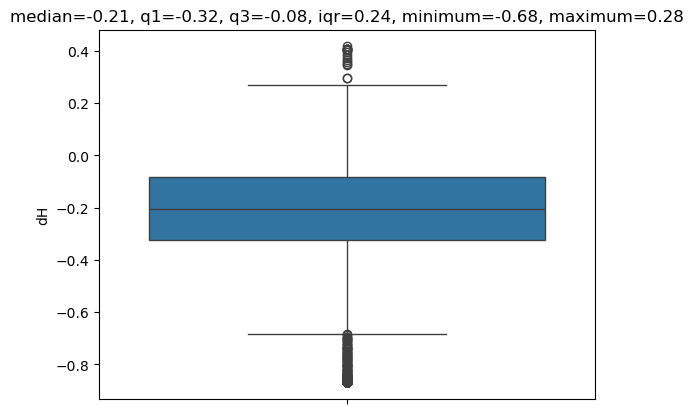

In [28]:
box_and_whisker(dico['pression'], 'dH')

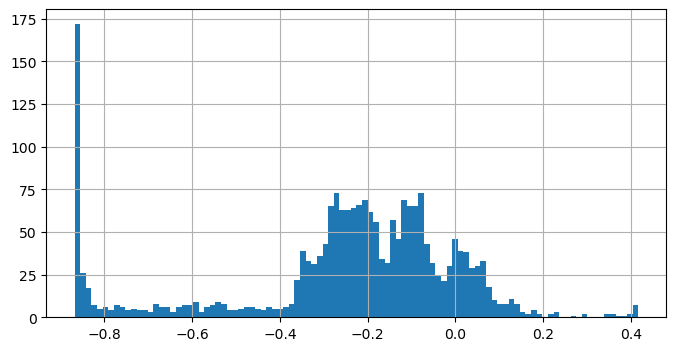

In [29]:
dico['pression']["dH"].hist(bins=100,figsize=(8,4))
plt.show()

### Suppression des valeurs aberrantes et visualisation du résultat

Après avoir fait tout le gros du travail dans les fonctions d'assistance, nous pouvons maintenant supprimer les lignes des données qui contiennent des valeurs aberrantes en dehors de | - et - | moustaches…



In [30]:
# Créez une copie de la DataFrame originale avec les valeurs aberrantes supprimées
dico['pression_iqr'] = dico['pression'].copy()


# Liste des noms de colonnes à traiter (à l'exception des colonnes "dates" et "tension_V")
columns_to_process = [col for col in dico['pression'].columns if col not in ["dates", "tension_V"]]

# Appliquez la fonction remove_outliers à chaque colonne de la liste
for col_name in columns_to_process:
    dico['pression_iqr'] = remove_outliers(dico['pression_iqr'], col_name)
print(dico['pression_iqr'].describe())

                               dates    tension_V  temperature_stream_C  \
count                           1818  1818.000000           1818.000000   
mean   2016-07-22 02:49:47.623762432     1.489371             14.243377   
min              2016-07-12 14:45:00     0.836390             11.783000   
25%              2016-07-17 08:18:45     1.338830             13.570000   
50%              2016-07-22 03:37:30     1.497865             14.146000   
75%              2016-07-26 21:11:15     1.627590             14.936000   
max              2016-07-31 14:45:00     2.228330             16.844000   
std                              NaN     0.237010              1.002637   

                dH  
count  1818.000000  
mean     -0.176475  
min      -0.680958  
25%      -0.270209  
50%      -0.181740  
75%      -0.074040  
max       0.270346  
std       0.161675  


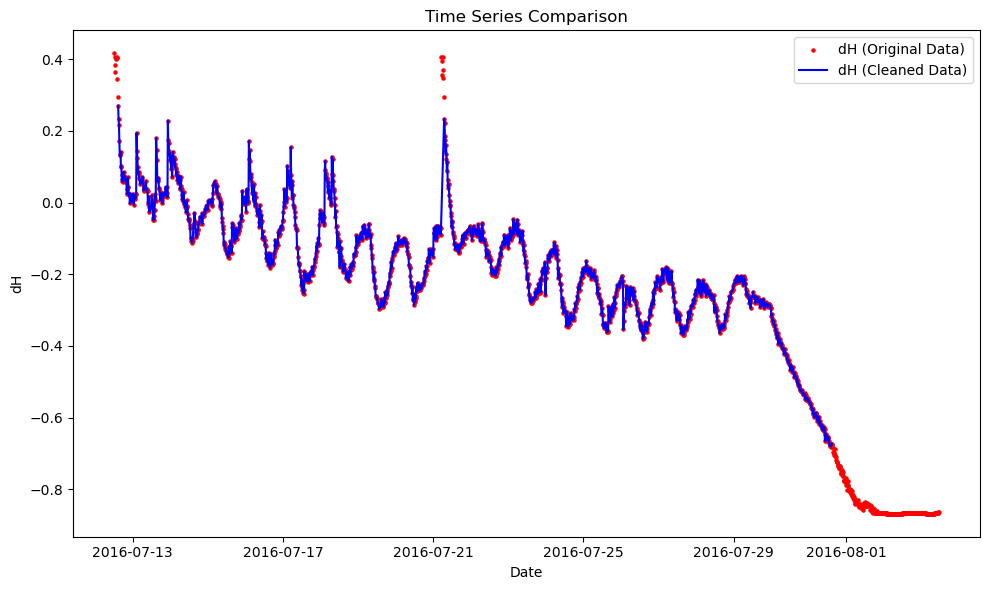

In [31]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['pression']["dates"], dico['pression']["dH"], color="red", label="dH (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['pression_iqr']["dates"], dico['pression_iqr'] ["dH"], color="blue", label="dH (Cleaned Data)")

# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("dH")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

### b) Valeurs abérantes avec la méthode score Z 
Il s'agit d'une unité mesurée en écart-type. Fondamentalement, il s'agit d'une mesure de la distance entre le score brut et la moyenne. Il est compris entre -3 et +3, où 0 = moyenne et 1 = écart-type, c'est-à-dire une distribution normale.

Cette méthode suggère qu'en tout point de données il existe une relation entre l'écart-type et la moyenne. Le score Z permet de trouver la distribution des données où la moyenne est égale à 0 et l'écart-type à 1, c'est-à-dire une distribution normale. Vous devez vous demander en quoi cela peut nous aider à identifier les valeurs aberrantes ? 


Le score Z est un concept important en statistique. Le score Z est également appelé score standard. Ce score permet de comprendre si une valeur de données est supérieure ou inférieure à la moyenne et à quel point elle s'en éloigne. Plus précisément, le score Z indique le nombre d'écarts types d'un point de données par rapport à la moyenne.

        Z score = (x -mean) / std. deviation

Une distribution normale est représentée ci-dessous et on estime que
* 68% des points de données se situent entre +/- 1 écart-type.
* 95 % des points de données se situent entre +/- 2 écarts types
* 99,7 % des points de données se situent entre +/- 3 écarts types.


En calculant le score Z, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Ces points de données qui sont trop éloignés de zéro seront traités comme des valeurs aberrantes. Dans la plupart des cas, un seuil de 3 ou -3 est utilisé, c'est-à-dire que si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme aberrant.



In [32]:
# Liste des colonnes à traiter (sans "dates" et "tension_V")
columns_to_process = [col for col in dico['pression'].columns if col not in ["dates", "tension_V"]]

# Définir un seuil pour le Z-score 
threshold = 2.5

# Créer un DataFrame vide pour stocker les données traitées
dico['pression_zscore'] = dico['pression'][["dates"]].copy()

""" CODE D'ORIGINE : 
# Boucler à travers chaque colonne à traiter
for column_name in columns_to_process:
    # Calculer le Z-score pour la colonne
    valid_values = dico['pression'][column_name].dropna()  # Ignorer les valeurs NaN
    z_scores = np.abs(stats.zscore(valid_values))
    
    # Sélectionner les lignes avec des Z-scores inférieurs au seuil
    df_cleaned = dico['pression'].loc[valid_values.index][z_scores < threshold]
    
    # Copier les données traitées dans dico['pression_zscore'] pour cette colonne
    dico['pression_zscore'][column_name] = df_cleaned[column_name]
"""

# Nettoyage de la colonne dH :
# Calculer le Z-score pour la colonne
valid_values = dico['pression']['dH'].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['pression'].loc[valid_values.index][z_scores < threshold]
    
# Copier les données traitées dans dico['pression_zscore'] pour cette colonne
dico['pression_zscore']['dH'] = df_cleaned['dH']

# Afficher les statistiques des données traitées
print(dico['pression_zscore'].info())

<class 'pandas.core.frame.DataFrame'>
Index: 2108 entries, 1 to 2108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   2108 non-null   datetime64[ns]
 1   dH      2108 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.9 KB
None


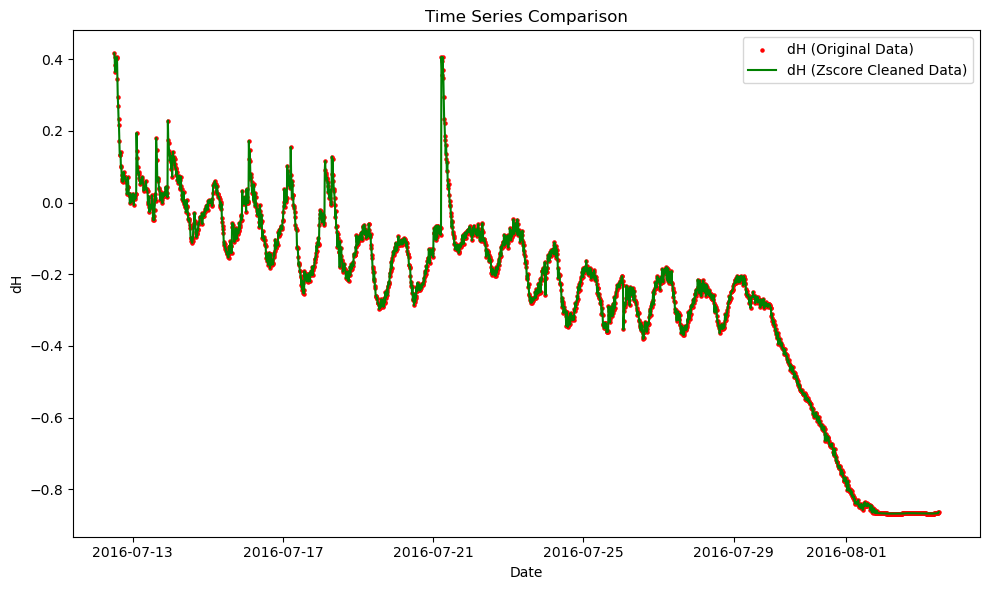

In [33]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['pression']["dates"], dico['pression']["dH"], color="red", label="dH (Original Data)", s=5)



# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['pression_zscore']["dates"], dico['pression_zscore'] ["dH"], color="green", label="dH (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("dH")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

→ On constate, avec l'affichage précédent du nombre de NaN, qu'aucune donnée n'a été supprimée.

### Essayer en modifant la valeur du  threshold


→ Empiriquement, une valeur seuil de z-score de 1.6 semble être la plus appropriée pour ces valeurs de pression. Elle permet de ne pas dénaturer le signal, tout en supprimant une partie des données dans la fin de l'enregistrement, qui semble un peu aberrant. Avec ce seuil, on obtient un nombre de NaN très proche du nombre de valeurs restantes après le nettoyage IQR (1816 et 1818 valeurs respectivement).

In [34]:
# Liste des colonnes à traiter (sans "dates" et "tension_V")
columns_to_process = [col for col in dico['pression'].columns if col not in ["dates", "tension_V"]]

# Définir un seuil pour le Z-score 
threshold = 1.6

""" CODE D'ORIGINE : 
# Boucler à travers chaque colonne à traiter
for column_name in columns_to_process:
    # Calculer le Z-score pour la colonne
    valid_values = dico['pression'][column_name].dropna()  # Ignorer les valeurs NaN
    z_scores = np.abs(stats.zscore(valid_values))
    
    # Sélectionner les lignes avec des Z-scores inférieurs au seuil
    df_cleaned = dico['pression'].loc[valid_values.index][z_scores < threshold]
    
    # Copier les données traitées dans dico['pression_zscore'] pour cette colonne
    dico['pression_zscore'][column_name] = df_cleaned[column_name]
"""

# Nettoyage de la colonne dH :
# Calculer le Z-score pour la colonne
valid_values = dico['pression']['dH'].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['pression'].loc[valid_values.index][z_scores < threshold]
    
# Copier les données traitées dans dico['pression_zscore'] pour cette colonne
dico['pression_zscore']['dH'] = df_cleaned['dH']

# Afficher les statistiques des données traitées
print(dico['pression_zscore'].info())

<class 'pandas.core.frame.DataFrame'>
Index: 2108 entries, 1 to 2108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   2108 non-null   datetime64[ns]
 1   dH      1816 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.9 KB
None


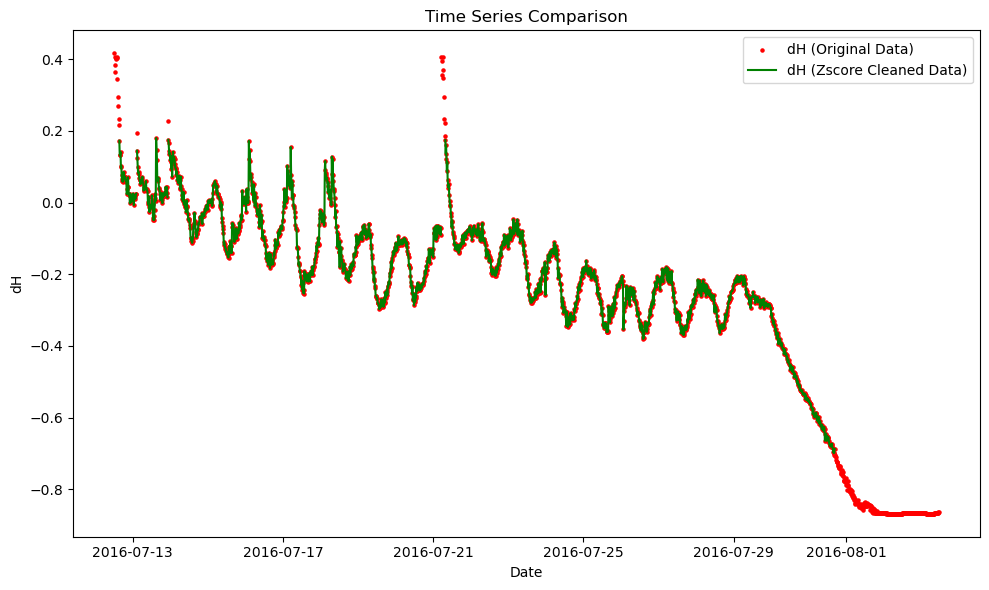

In [35]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['pression']["dates"], dico['pression']["dH"], color="red", label="dH (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['pression_zscore']["dates"], dico['pression_zscore'] ["dH"], color="green", label="dH (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("dH")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

## 5.2 Application pratique : nettoyage des données de temperature de rivière
___

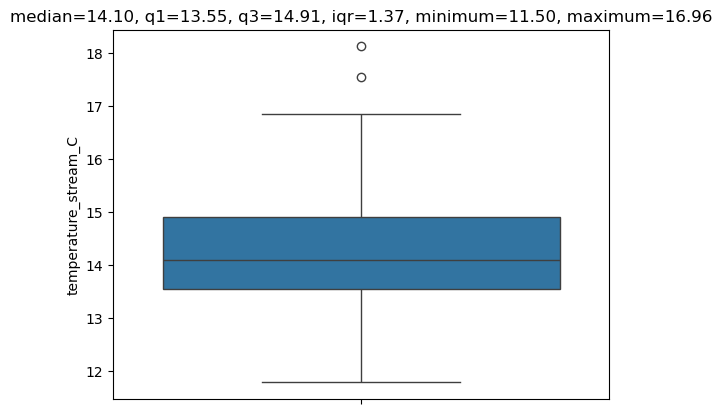

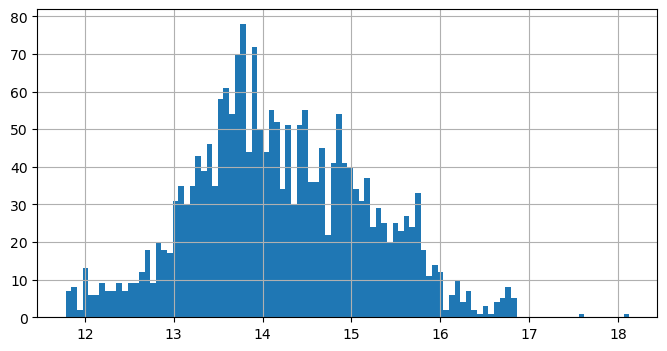

In [36]:
#Quelques affichages des données de température de rivière

box_and_whisker(dico['pression'], 'temperature_stream_C')

dico['pression']["temperature_stream_C"].hist(bins=100,figsize=(8,4))
plt.show()

#### Suppression des lignes des données qui contiennent des valeurs aberrantes avec la méthode IQR :

In [37]:
# Ci-dessus, on a déjà créé une copie de la DataFrame originale avec les valeurs aberrantes supprimées dico['pression_iqr'],
# puis on a appliqué la fonction remove_outliers à chaque colonne appropriée du dataframe
# Ici on se contente donc d'afficher les résultats

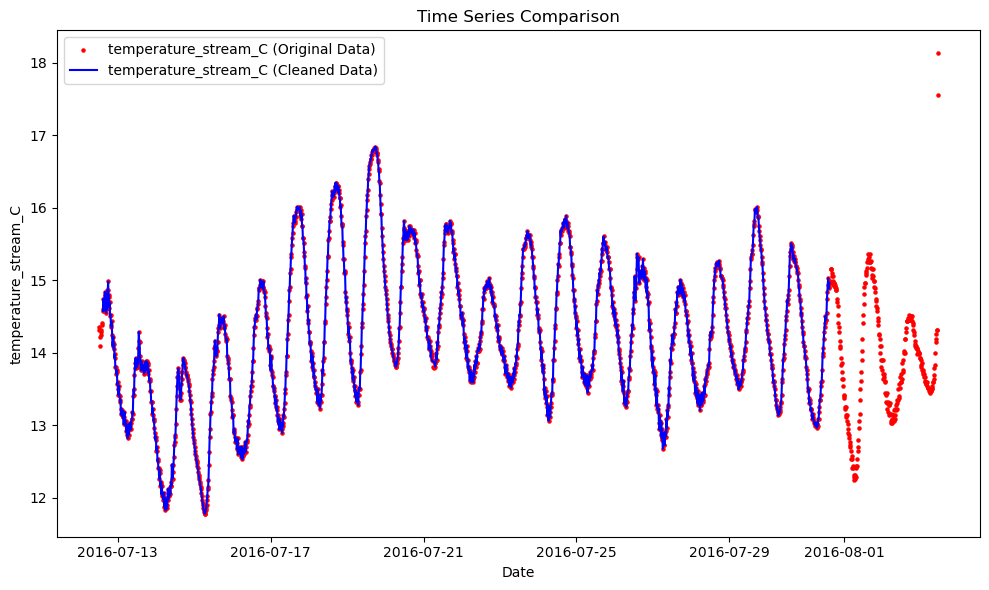

In [38]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['pression']["dates"], dico['pression']["temperature_stream_C"], color="red", label="temperature_stream_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['pression_iqr']["dates"], dico['pression_iqr'] ["temperature_stream_C"], color="blue", label="temperature_stream_C (Cleaned Data)")

# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_stream_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

→ On constate qu'une partie des données (les plus récentes) a été supprimée sans raison objective. Ceci nous motive à obtenir un meilleur nettoyage avec la méthode reposant sur le z-score.

#### Suppression des lignes des données qui contiennent des valeurs aberrantes avec le Z-score :

On a peut déjà essayer un traitement avec un z-score seuil de 2.5 :

In [39]:
dico['pression_zscore'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2108 entries, 1 to 2108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   2108 non-null   datetime64[ns]
 1   dH      1816 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.9 KB


In [40]:
# Définir un seuil pour le Z-score 
threshold = 2.5

# Calculer le Z-score pour la colonne "temperature_stream_C"
valid_values = dico['pression']["temperature_stream_C"].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['pression'].loc[valid_values.index][z_scores < threshold]

# Copier les données traitées dans dico['pression_zscore'] pour cette colonne
dico['pression_zscore']["temperature_stream_C"] = df_cleaned["temperature_stream_C"]
# A cette étape, les valeurs aberrantes sont remplacées par NaN 

# Afficher les statistiques des données traitées
print(dico['pression_zscore'].info())

<class 'pandas.core.frame.DataFrame'>
Index: 2108 entries, 1 to 2108
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   dates                 2108 non-null   datetime64[ns]
 1   dH                    1816 non-null   float64       
 2   temperature_stream_C  2088 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 130.4 KB
None


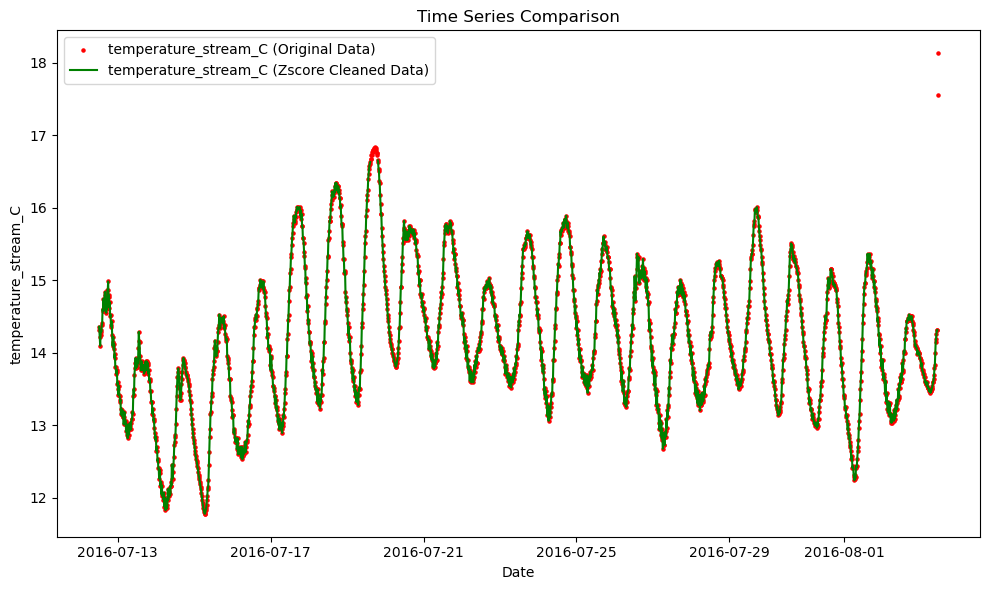

In [41]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['pression']["dates"], dico['pression']["temperature_stream_C"], color="red", label="temperature_stream_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['pression_zscore']["dates"], dico['pression_zscore']["temperature_stream_C"], color="green", label="temperature_stream_C (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_stream_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

→ On remarques que les pics (maximums et minimums) sont trop écrétés dans le jeu de données traitées avec le z-score. On essaie donc progressivement des seuils, jusqu'à celui de 3, dans l'idée de limiter l'écrêtage pour ne pas supprimer des données d'intérêt. Cela semble d'autant plus pertinent qu'il semble y avoir un nombre très limité de valeurs aberrantes :

In [42]:
# Définir un seuil pour le Z-score 
threshold = 3

# Calculer le Z-score pour la colonne "temperature_stream_C"
valid_values = dico['pression']["temperature_stream_C"].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['pression'].loc[valid_values.index][z_scores < threshold]

# Copier les données traitées dans dico['pression_zscore'] pour cette colonne
dico['pression_zscore']["temperature_stream_C"] = df_cleaned["temperature_stream_C"]
# A cette étape, les valeurs aberrantes sont remplacées par NaN 

# Afficher les statistiques des données traitées
print(dico['pression_zscore'].info())

<class 'pandas.core.frame.DataFrame'>
Index: 2108 entries, 1 to 2108
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   dates                 2108 non-null   datetime64[ns]
 1   dH                    1816 non-null   float64       
 2   temperature_stream_C  2106 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 130.4 KB
None


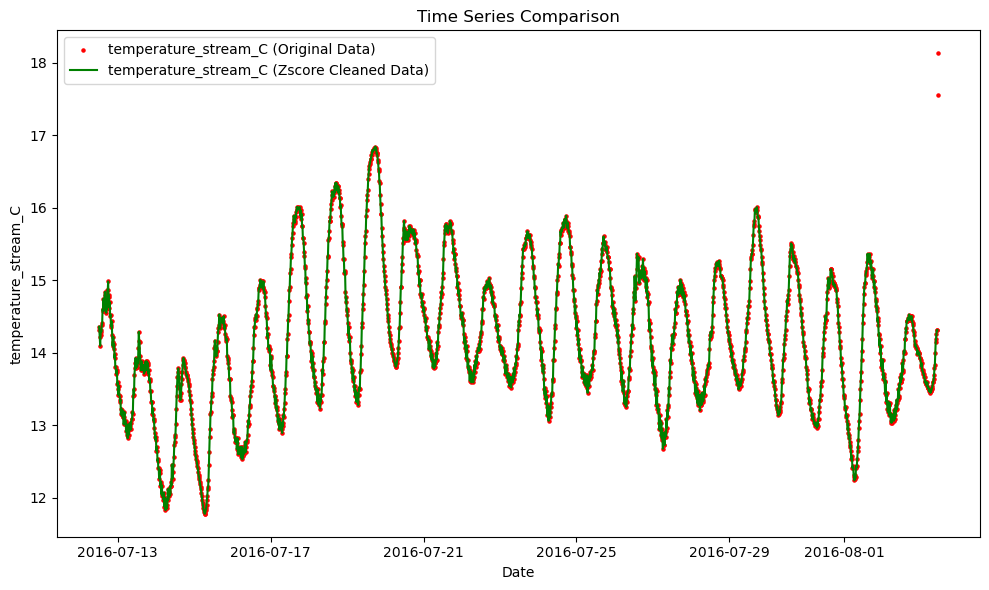

In [43]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['pression']["dates"], dico['pression']["temperature_stream_C"], color="red", label="temperature_stream_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['pression_zscore']["dates"], dico['pression_zscore']["temperature_stream_C"], color="green", label="temperature_stream_C (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_stream_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

→ On préfère cette méthode de nettoyage des données utilisant le z-score (plutôt que celle reposant sur l'écart inter-quartile), puisque l'on observe que c'est elle qui, avec un bon seuil, permet de supprimer les quelques points aberrants sans pour autant dénaturer le reste des signaux obtenus.

## 5.3 Application pratique : nettoyage des données de températures dans le sédiments
___

→ Dans le cas de la mesure des températures dans la couche de sol, pour chacun des capteurs, on a préféré la méthode de nettoyage des données utilisant le z-score (plutôt que celle reposant sur l'écart inter-quartile), puisque dans ce cas aussi c'est elle qui, avec un bon seuil, permet de supprimer les quelques points aberrants sans pour autant dénaturer le reste des signaux obtenus.

#### 1) Température capteur C1 :

##### Méthode IQR :

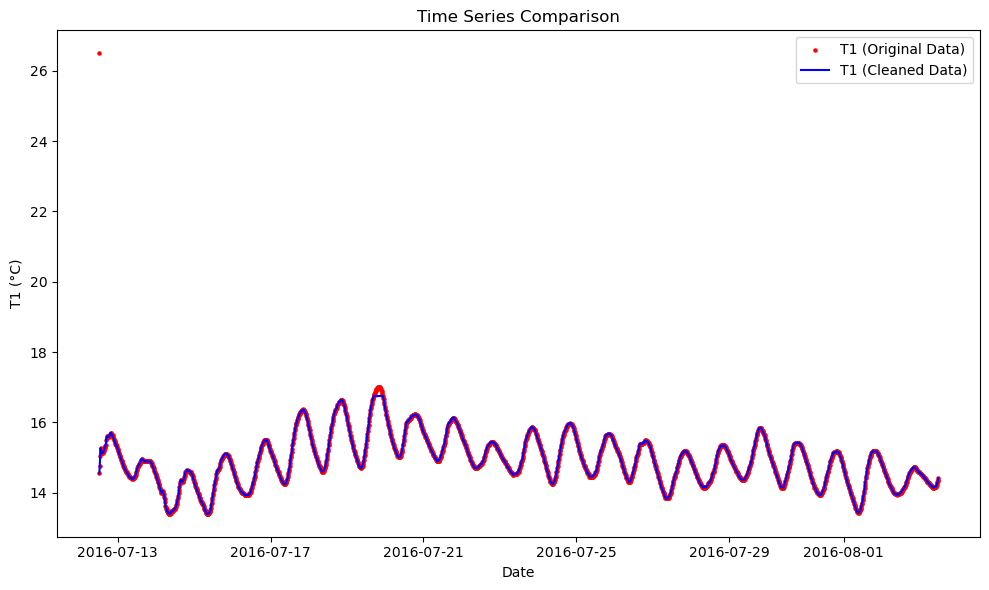

In [44]:
# Créez une copie de la DataFrame originale avec les valeurs aberrantes supprimées
dico['temperature_iqr'] = dico['temperature'].copy()

dico['temperature_iqr'] = remove_outliers(dico['temperature_iqr'], 'temperature_depth_1_C')

# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_1_C"], color="red", label="T1 (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_iqr']["dates"], dico['temperature_iqr'] ["temperature_depth_1_C"], color="blue", label="T1 (Cleaned Data)")

# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("T1 (°C)")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()


#### Méthode Z-score :

In [45]:
# Définir un seuil pour le Z-score 
threshold = 3

# Créer un DataFrame vide pour stocker les données traitées
dico['temperature_zscore'] = dico['temperature'][["dates"]].copy()

# Calculer le Z-score pour la colonne "temperature_depth_1_C"
valid_values = dico['temperature']["temperature_depth_1_C"].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['temperature'].loc[valid_values.index][z_scores < threshold]

# Copier les données traitées dans dico['temperature_zscore'] pour cette colonne
dico['temperature_zscore']["temperature_depth_1_C"] = df_cleaned["temperature_depth_1_C"]

# Afficher les statistiques des données traitées
print(dico['temperature_zscore'].info())


<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 1 to 2110
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dates                  2110 non-null   datetime64[ns]
 1   temperature_depth_1_C  2109 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 114.0 KB
None


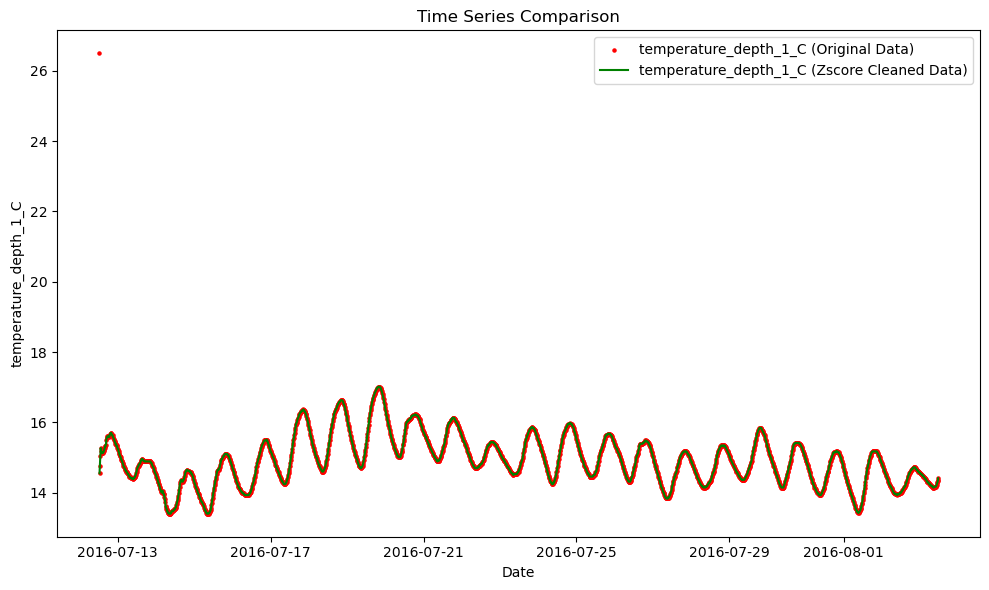

In [46]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_1_C"], color="red", label="temperature_depth_1_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_zscore']["dates"], dico['temperature_zscore'] ["temperature_depth_1_C"], color="green", label="temperature_depth_1_C (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_depth_1_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

#### 2) Température capteur C2 :

##### Méthode IQR :

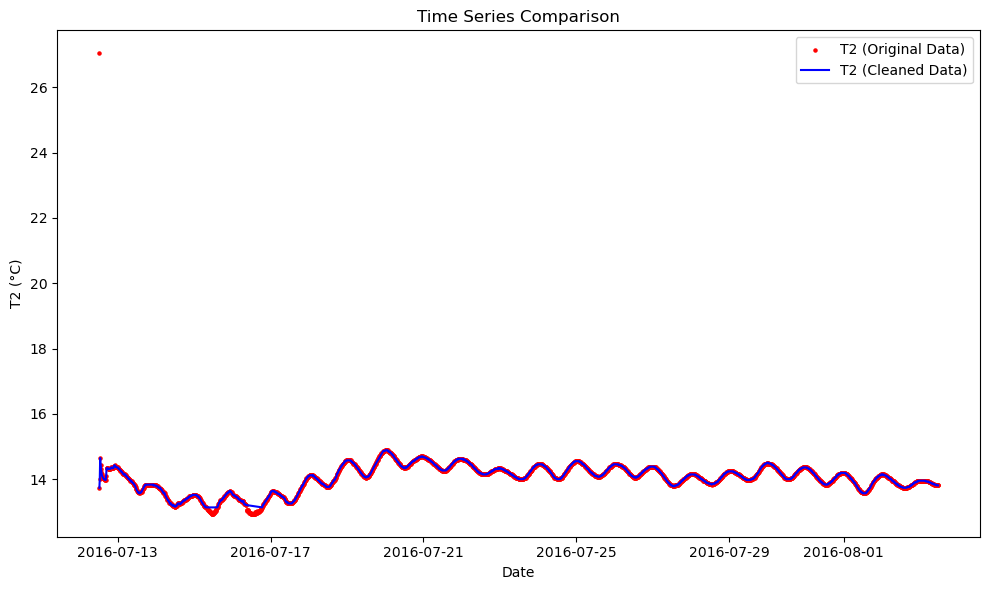

In [47]:
dico['temperature_iqr'] = remove_outliers(dico['temperature_iqr'], 'temperature_depth_2_C')

# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_2_C"], color="red", label="T2 (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_iqr']["dates"], dico['temperature_iqr'] ["temperature_depth_2_C"], color="blue", label="T2 (Cleaned Data)")

# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("T2 (°C)")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()


#### Méthode Z-score :

In [48]:
# Définir un seuil pour le Z-score 
threshold = 3

# Calculer le Z-score pour la colonne "temperature_depth_1_C"
valid_values = dico['temperature']["temperature_depth_2_C"].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['temperature'].loc[valid_values.index][z_scores < threshold]

# Copier les données traitées dans dico['temperature_zscore'] pour cette colonne
dico['temperature_zscore']["temperature_depth_2_C"] = df_cleaned["temperature_depth_2_C"]

# Afficher les statistiques des données traitées
print(dico['temperature_zscore'].describe())


                               dates  temperature_depth_1_C  \
count                           2110            2109.000000   
mean   2016-07-23 11:52:29.185782016              14.929127   
min              2016-07-12 12:15:00              13.401000   
25%              2016-07-18 00:03:45              14.433000   
50%              2016-07-23 11:52:30              14.888000   
75%              2016-07-28 23:41:15              15.366000   
max              2016-08-03 11:09:23              17.011000   
std                              NaN               0.703856   

       temperature_depth_2_C  
count            2109.000000  
mean               14.030653  
min                12.944000  
25%                13.834000  
50%                14.098000  
75%                14.314000  
max                14.888000  
std                 0.404423  


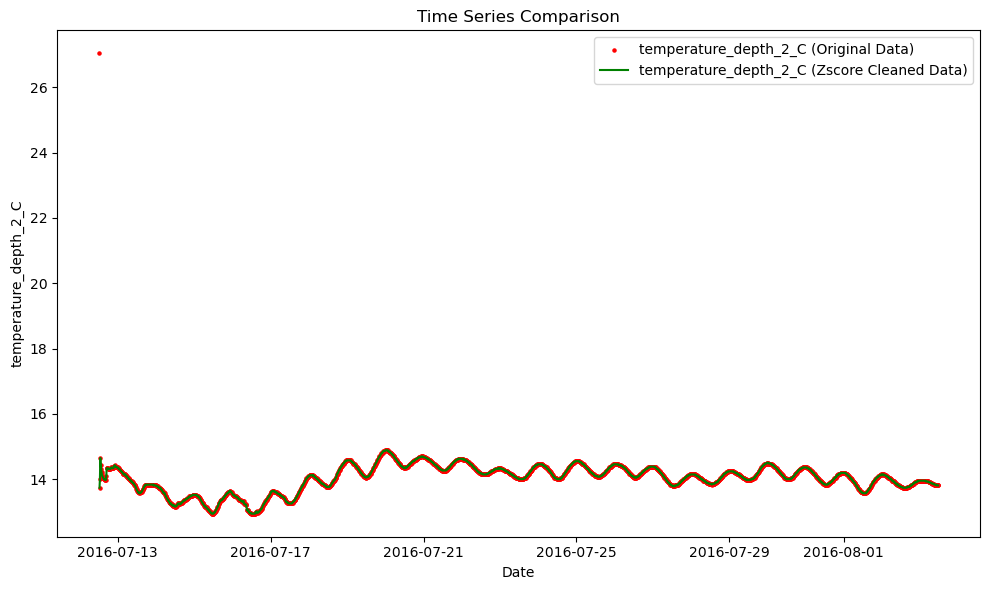

In [49]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_2_C"], color="red", label="temperature_depth_2_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_zscore']["dates"], dico['temperature_zscore'] ["temperature_depth_2_C"], color="green", label="temperature_depth_2_C (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_depth_2_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

#### 3) Température capteur C3 :

##### Méthode IQR :

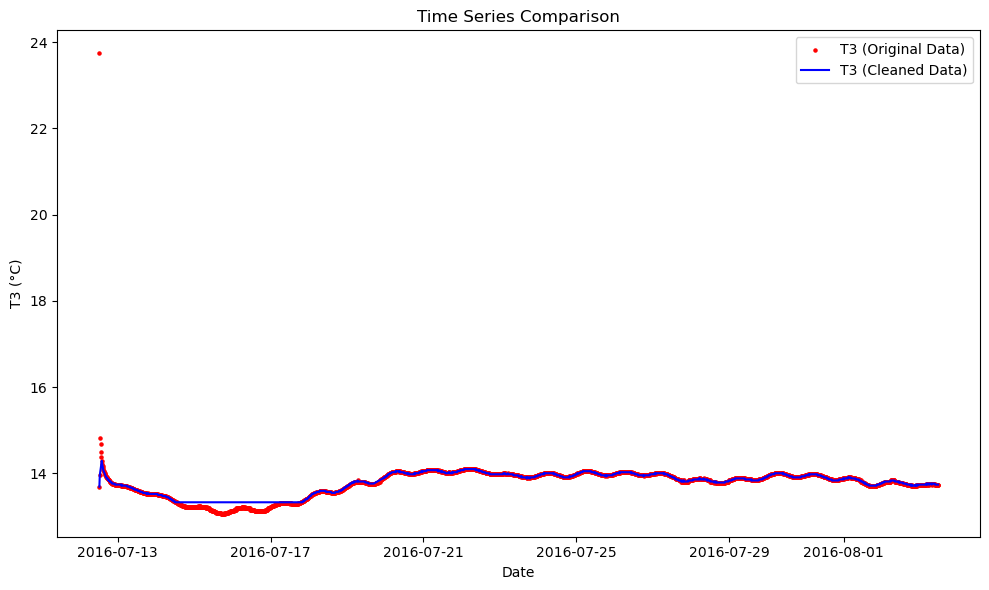

In [50]:
dico['temperature_iqr'] = remove_outliers(dico['temperature_iqr'], 'temperature_depth_3_C')

# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_3_C"], color="red", label="T3 (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_iqr']["dates"], dico['temperature_iqr'] ["temperature_depth_3_C"], color="blue", label="T3 (Cleaned Data)")

# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("T3 (°C)")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()


#### Méthode Z-score :

In [51]:
# Définir un seuil pour le Z-score 
threshold = 3

# Calculer le Z-score pour la colonne "temperature_depth_3_C"
valid_values = dico['temperature']["temperature_depth_3_C"].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['temperature'].loc[valid_values.index][z_scores < threshold]

# Copier les données traitées dans dico['temperature_zscore'] pour cette colonne
dico['temperature_zscore']["temperature_depth_3_C"] = df_cleaned["temperature_depth_3_C"]

# Afficher les statistiques des données traitées
print(dico['temperature_zscore'].describe())


                               dates  temperature_depth_1_C  \
count                           2110            2109.000000   
mean   2016-07-23 11:52:29.185782016              14.929127   
min              2016-07-12 12:15:00              13.401000   
25%              2016-07-18 00:03:45              14.433000   
50%              2016-07-23 11:52:30              14.888000   
75%              2016-07-28 23:41:15              15.366000   
max              2016-08-03 11:09:23              17.011000   
std                              NaN               0.703856   

       temperature_depth_2_C  temperature_depth_3_C  
count            2109.000000            2109.000000  
mean               14.030653              13.764072  
min                12.944000              13.064000  
25%                13.834000              13.642000  
50%                14.098000              13.858000  
75%                14.314000              13.978000  
max                14.888000              14.816000  


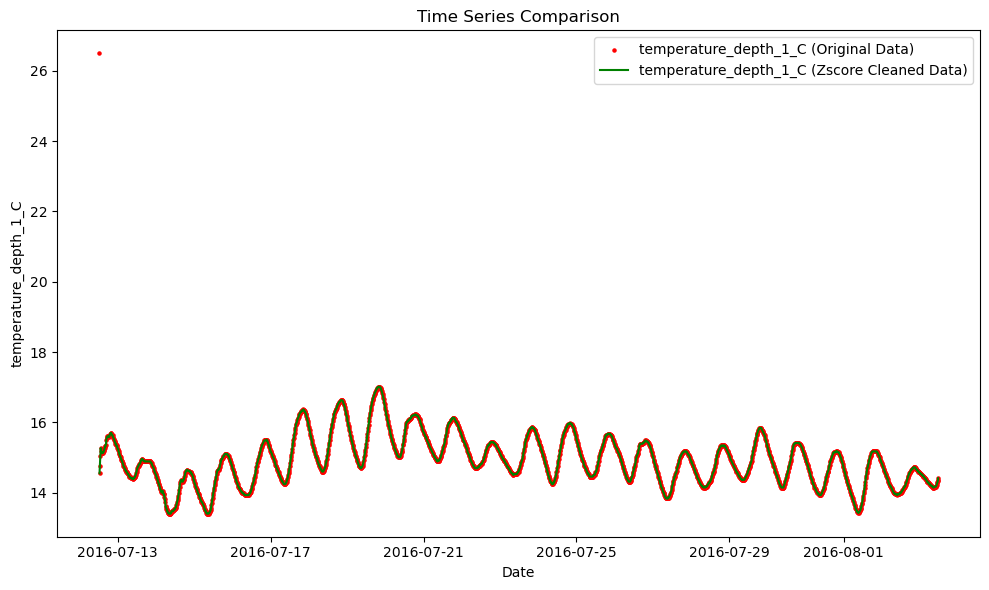

In [52]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_1_C"], color="red", label="temperature_depth_1_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_zscore']["dates"], dico['temperature_zscore'] ["temperature_depth_1_C"], color="green", label="temperature_depth_1_C (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_depth_1_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

#### 4) Température capteur C4 :

##### Méthode IQR :

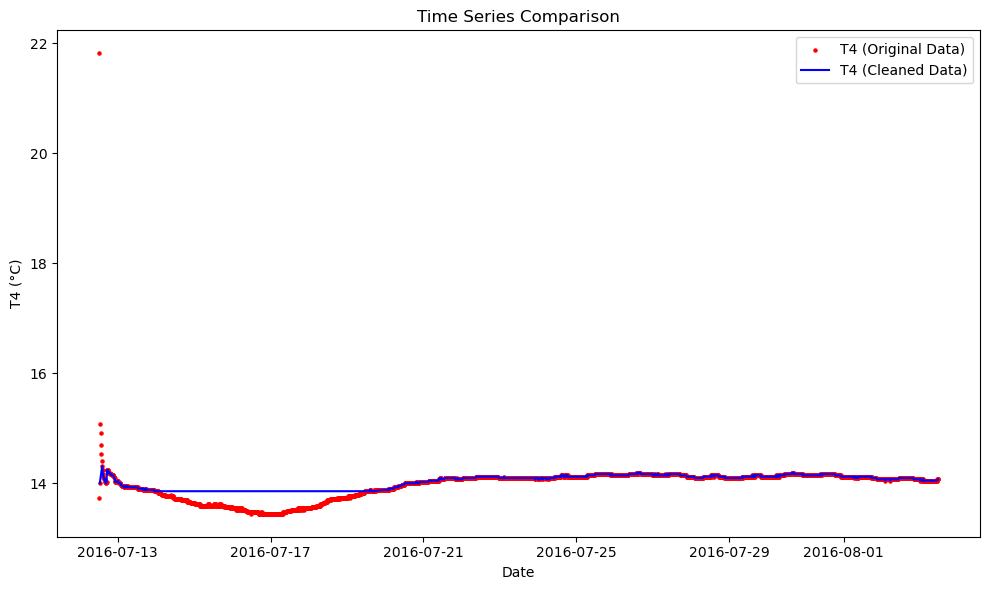

In [53]:


dico['temperature_iqr'] = remove_outliers(dico['temperature_iqr'], 'temperature_depth_4_C')

# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_4_C"], color="red", label="T4 (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_iqr']["dates"], dico['temperature_iqr'] ["temperature_depth_4_C"], color="blue", label="T4 (Cleaned Data)")

# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("T4 (°C)")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()


#### Méthode Z-score :

In [54]:
# Définir un seuil pour le Z-score 
threshold = 3

#print(dico['temperature'].describe())

# Calculer le Z-score pour la colonne "temperature_depth_4_C"
valid_values = dico['temperature']["temperature_depth_4_C"].dropna()  # Ignorer les valeurs NaN
z_scores = np.abs(stats.zscore(valid_values))
    
# Sélectionner les lignes avec des Z-scores inférieurs au seuil
df_cleaned = dico['temperature'].loc[valid_values.index][z_scores < threshold]

# Copier les données traitées dans dico['temperature_zscore'] pour cette colonne
dico['temperature_zscore']["temperature_depth_4_C"] = df_cleaned["temperature_depth_4_C"]

# Afficher les statistiques des données traitées
print(dico['temperature_zscore'].describe())


                               dates  temperature_depth_1_C  \
count                           2110            2109.000000   
mean   2016-07-23 11:52:29.185782016              14.929127   
min              2016-07-12 12:15:00              13.401000   
25%              2016-07-18 00:03:45              14.433000   
50%              2016-07-23 11:52:30              14.888000   
75%              2016-07-28 23:41:15              15.366000   
max              2016-08-03 11:09:23              17.011000   
std                              NaN               0.703856   

       temperature_depth_2_C  temperature_depth_3_C  temperature_depth_4_C  
count            2109.000000            2109.000000            2107.000000  
mean               14.030653              13.764072              13.971725  
min                12.944000              13.064000              13.449000  
25%                13.834000              13.642000              13.858000  
50%                14.098000              13.85

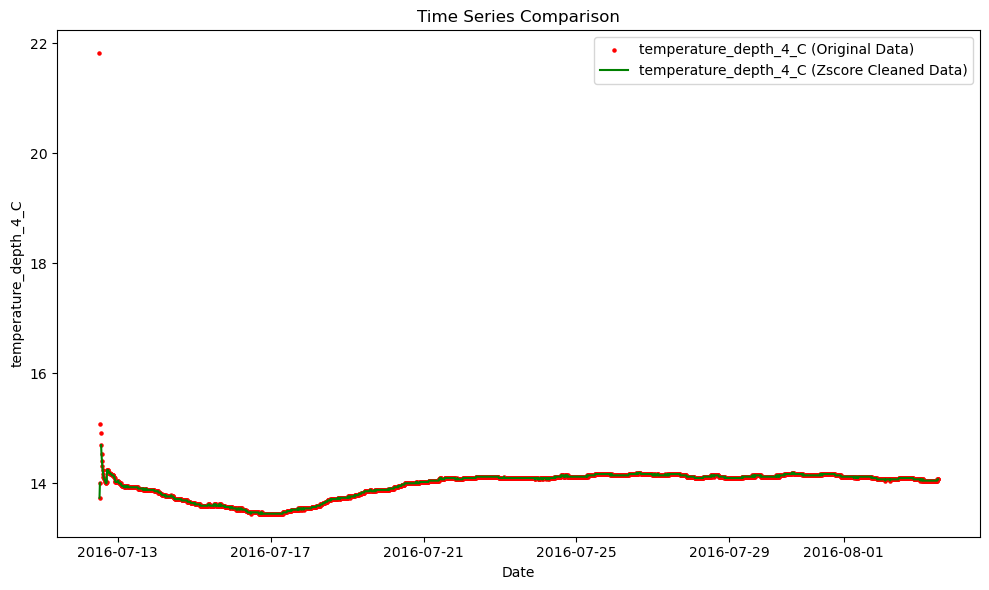

In [55]:
# Créez une figure et un axe (un seul sous-graphique)
fig, ax = plt.subplots(figsize=(10, 6))

# Tracez les données de 'df' avec des points
ax.scatter(dico['temperature']["dates"], dico['temperature']["temperature_depth_4_C"], color="red", label="temperature_depth_4_C (Original Data)", s=5)

# Tracez les données de 'df_cleaned' avec des lignes continues
ax.plot(dico['temperature_zscore']["dates"], dico['temperature_zscore'] ["temperature_depth_4_C"], color="green", label="temperature_depth_4_C (Zscore Cleaned Data)")


# Configurez les étiquettes et la légende
ax.set_xlabel("Date")
ax.set_ylabel("temperature_depth_4_C")
ax.set_title("Time Series Comparison")
ax.legend()

# Affichez la figure
plt.tight_layout()
plt.show()

## 5.4 Vérifier la taille des données
___

In [56]:
dico.keys()

dict_keys(['chemin', 'capteur', 'profondeur', 'pression', 'temperature', 'intercept', 'dU/dH', 'dU/dT', 'pression_iqr', 'pression_zscore', 'temperature_iqr', 'temperature_zscore'])

→ On a retenu la méthode IQR oou z-score pour éliminer les données aberrantes de dH et la méthode la méthode du z-score pour nettoyer les données de température, que ce soit dans la rivière ou dans les sédiments. Il s'agit désormais d'actualiser les données avec celles netoyées (en choisissant donc celles des 2 dataframes purifiés gâce aux calculs de z-score). 

In [62]:
# On a modifié le code ci-dessous pour bien prendre en compte le mode de nettoyage retenu (Z-score)

# D'abord, vérifier la taille des données en supprimant les lignes contenant des NaN (valeurs aberrantes)
print("Taille données pression:", len(dico['pression_zscore'].dropna()))
print("Taille données température:", len(dico['temperature_zscore'].dropna()))

# Synchroniser les données en utilisant les dates communes
# Trouver les dates communes entre les deux DataFrames
dates_communes = pd.merge(
    dico['pression_zscore'].dropna()[['dates']], 
    dico['temperature_zscore'].dropna()[['dates']], 
    on='dates', 
    how='inner'
)['dates']

print(f"Nombre de dates communes: {len(dates_communes)}")

# Filtrer les DataFrames pour ne garder que les dates communes
dico['pression_sync'] = dico['pression'][dico['pression']['dates'].isin(dates_communes)].reset_index(drop=True)
dico['temperature_sync'] = dico['temperature'][dico['temperature']['dates'].isin(dates_communes)].reset_index(drop=True)

# Trier par date pour s'assurer que l'ordre est le même
dico['pression_sync'] = dico['pression_sync'].sort_values('dates').reset_index(drop=True)
dico['temperature_sync'] = dico['temperature_sync'].sort_values('dates').reset_index(drop=True)

# Conversion des mesures de températures en utilisant les données synchronisées
dico['pression_sync'].loc[:, 'temperature_riviere'] = dico['pression_sync']['temperature_stream_C'] + ZERO_CELSIUS
dico['temperature_sync'].loc[:, 'temperature_10'] = dico['temperature_sync']['temperature_depth_1_C'] + ZERO_CELSIUS
dico['temperature_sync'].loc[:, 'temperature_20'] = dico['temperature_sync']['temperature_depth_2_C'] + ZERO_CELSIUS
dico['temperature_sync'].loc[:, 'temperature_30'] = dico['temperature_sync']['temperature_depth_3_C'] + ZERO_CELSIUS
dico['temperature_sync'].loc[:, 'temperature_40'] = dico['temperature_sync']['temperature_depth_4_C'] + ZERO_CELSIUS

# Vérifier que les tailles sont maintenant identiques
print("Taille données pression synchronisées:", len(dico['pression_sync']))
print("Taille données température synchronisées:", len(dico['temperature_sync']))

# Vérifier que les dates sont dans le même ordre
if not dico['pression_sync']['dates'].equals(dico['temperature_sync']['dates']):
    print("Attention: les dates ne correspondent pas exactement!")
else:
    print("Les dates sont synchronisées correctement")



Taille données pression: 1816
Taille données température: 2107
Nombre de dates communes: 1816
Taille données pression synchronisées: 1816
Taille données température synchronisées: 1816
Les dates sont synchronisées correctement


# 6. Modélisation hydrothermique avec pyheatmy
___

**Objectif :** Appliquer un modèle physique de transfert de chaleur et d'eau dans les sédiments de rivière pour estimer les paramètres hydrogéologiques.

## Principe de la modélisation

La modélisation hydrothermique des échanges eau-sédiment permet de quantifier les flux d'eau souterrains à partir des mesures de température et de pression. Cette approche s'appuie sur :

**Équations physiques fondamentales :**
- **Équation de transfert de chaleur** : Diffusion thermique dans les sédiments poreux
- **Équation de Darcy** : Écoulement de l'eau souterraine sous gradient hydraulique
- **Couplage hydrothermique** : Convection de la chaleur par l'eau en mouvement

**Variables d'état :**
- **Température** : Évolution spatio-temporelle dans la colonne sédimentaire
- **Charge hydraulique** : Gradient de pression moteur des écoulements
- **Flux de Darcy** : Vitesse verticale de l'eau souterraine

## Architecture du modèle pyheatmy

**Structure modulaire :**
- **Classe `Column`** : Représentation d'une colonne sédimentaire unidimensionnelle
- **Modèle direct** : Calcul des températures à partir des paramètres hydrogéologiques
- **Inversion bayésienne** : Estimation des paramètres par MCMC (Monte Carlo Markov Chain)

**Paramètres à déterminer :**
- **K** : Perméabilité intrinsèque (m²)
- **n** : Porosité efficace (sans dimension)
- **λₛ** : Conductivité thermique des solides (W/m/K)
- **ρc ₛ** : Capacité thermique volumique des solides (J/m³/K)

## Workflow de modélisation

**Étapes successives :**
1. **Préparation des données** : Synchronisation et nettoyage des séries temporelles
2. **Définition de la géométrie** : Configuration de la colonne et positionnement des capteurs
3. **Modèle direct initial** : Test avec des paramètres a priori
4. **Inversion bayésienne** : Optimisation des paramètres par MCMC
5. **Validation** : Analyse des résidus et de la qualité d'ajustement

> **🔬 Objectif scientifique :** Quantifier les échanges hyporhéiques entre la rivière et la nappe souterraine, processus fondamental pour comprendre le fonctionnement écologique et biogéochimique des systèmes fluviaux.


## 6.1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.


## 6.2 Présentation de la librairie pyheatmy
___

**Objectif de cette section :** Comprendre les fonctionnalités principales de la librairie `pyheatmy` pour la modélisation hydrothermique.

### Fonctionnalités principales

Ce notebook présente les diverses fonctionnalités de `pyheatmy`. Il explique comment :

- **Créer un objet `Column`** à partir d'une lecture simple des données de dates
- **Exécuter le modèle direct** pour des lits de rivière homogènes (section 6.3) et hétérogènes (section 6.4)
- **Exécuter l'inversion MCMC** pour l'estimation des paramètres
- **Récupérer et afficher** les divers résultats produits lors des exécutions du modèle direct ou du MCMC

### Notes importantes

**Méthode DREAM :** Ce notebook ne fournit pas encore d'informations sur la méthode DREAM implémentée en 2023. Pour cela, veuillez vous référer aux notebooks `DREAM_VX.ipynb`.

**Architecture de pyheatmy :** La librairie `pyheatmy` est construite autour de la classe monolithique `Column` dans `core.py`. Elle peut être exécutée à partir de cette classe. Les calculs, la récupération de données et les graphiques sont des méthodes fournies par la classe `Column`.

**Données réelles :** La modélisation est basée sur des données réelles, qui peuvent être trouvées dans le dossier `data` du projet.

> **📚 Documentation :** Nous recommandons la lecture de l'API pour plus de détails sur l'utilisation avancée de la librairie. 

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [58]:
# Conversion des mesures de températures en utilisant .loc pour éviter l'avertissement
dico['pression'].loc[:, 'temperature_riviere'] = dico['pression']['temperature_stream_C'] + ZERO_CELSIUS
dico['temperature'].loc[:, 'temperature_10'] = dico['temperature']['temperature_depth_1_C'] + ZERO_CELSIUS
dico['temperature'].loc[:, 'temperature_20'] = dico['temperature']['temperature_depth_2_C'] + ZERO_CELSIUS
dico['temperature'].loc[:, 'temperature_30'] = dico['temperature']['temperature_depth_3_C'] + ZERO_CELSIUS
dico['temperature'].loc[:, 'temperature_40'] = dico['temperature']['temperature_depth_4_C'] + ZERO_CELSIUS

# Définition des attributs de colonnes
# Définition des attributs de colonnes avec les données synchronisées
dH_measures = list(zip(
    dico['pression_sync']['dates'], 
    list(zip(dico['pression_sync']['dH'], dico['pression_sync']['temperature_riviere']))
))

T_measures = list(zip(
    dico['temperature_sync']['dates'], 
    dico['temperature_sync'][['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()
))

print(f"Nombre de mesures dH: {len(dH_measures)}")
print(f"Nombre de mesures T: {len(T_measures)}")

# Maintenant créer l'objet Column
Zbottom = 0.4

col_dict = {
    "river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
    "offset": .0,
    "dH_measures": dH_measures,
    "T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

try:
    col = Column.from_dict(col_dict)
    print("Objet Column créé avec succès!")
except Exception as e:
    print(f"Erreur lors de la création de l'objet Column: {e}")

Nombre de mesures dH: 1816
Nombre de mesures T: 1816


C:\Users\marti\AppData\Local\Temp\ipykernel_16920\3201034058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dico['pression'].loc[:, 'temperature_riviere'] = dico['pression']['temperature_stream_C'] + ZERO_CELSIUS


Objet Column créé avec succès!


On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [59]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.



Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

## 6.2 Modèle direct
____

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [60]:
moinslog10IntrinK = 11
n = .1
lambda_s = 2
rhos_cs = 4e6
params = Param(moinslog10IntrinK,n,lambda_s,rhos_cs,1e-20)

# assert params == params_tuple

Puis on appelle le modèle direct :

In [61]:
col.compute_solve_transi(params, nb_cells=100)

TypeError: Column.compute_solve_transi() got an unexpected keyword argument 'nb_cells'

Et on utilise les méthodes de récupération des résultats et de tracer

In [ ]:
col.plot_temperature_at_sensors()

nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

Calcul des écarts de température et comparaison des températures simulées et observées

In [ ]:
col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()

## 6.3 Bayesian inversion
_____

In [ ]:
priors = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

all_priors = [
    ['Couche 1', Zbottom, priors],
]
col.compute_mcmc(
    nb_iter = 500,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2=1.0,
    verbose=False
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers, nb_cells=100,verbose=False)
col.plot_all_results()

# 7. Étude comparative : impact du traitement des données sur l'inversion
___

**Objectif :** Quantifier l'impact du nettoyage des données sur la qualité et la robustesse de l'inversion hydrothermique en comparant les résultats obtenus avec différents jeux de données.

## Problématique scientifique

Dans cette section cruciale, vous allez démontrer expérimentalement pourquoi le traitement rigoureux des données est essentiel pour une modélisation hydrothermique fiable. Cette analyse comparative révèle l'impact direct de la qualité des données sur :

**Paramètres estimés :**
- **Perméabilité (K)** : Capacité du sédiment à laisser passer l'eau
- **Porosité (n)** : Fraction de vide dans le milieu poreux
- **Propriétés thermiques** : Conductivité et capacité thermiques

**Qualité de l'ajustement :**
- **RMSE** : Écart quadratique moyen entre observations et simulations
- **Convergence MCMC** : Stabilité de l'algorithme d'optimisation
- **Incertitudes** : Intervalles de confiance des paramètres estimés

## Protocole expérimental

### Étape 1 : Préparation des jeux de données

Vous devez créer **quatre configurations** différentes pour l'analyse comparative :

1. **Données brutes** : `dico['pression']` et `dico['temperature']` (aucun traitement)
2. **Nettoyage IQR** : `dico['pression_iqr']` (méthode des quartiles)
3. **Nettoyage Z-score** : `dico['pression_zscore']` (méthode statistique)
4. **Données optimales** : Votre choix justifié du meilleur traitement

### Étape 2 : Inversions MCMC comparatives

Pour chaque jeu de données, vous devez :

1. **Créer l'objet Column** avec les données spécifiques
2. **Lancer l'inversion MCMC** avec les mêmes paramètres a priori
3. **Récupérer les paramètres optimaux** et leurs incertitudes
4. **Calculer les métriques de performance** (RMSE, convergence)

### Étape 3 : Analyse comparative détaillée

**Comparaisons quantitatives à effectuer :**

| Critère | Données brutes | IQR | Z-score | Optimal |
|---------|---------------|-----|---------|---------|
| RMSE température (°C) | ? | ? | ? | ? |
| Perméabilité log₁₀(K) | ? | ? | ? | ? |
| Porosité n | ? | ? | ? | ? |
| Temps de convergence | ? | ? | ? | ? |
| Stabilité des chaînes | ? | ? | ? | ? |

## Questions de réflexion

**Analyse critique attendue :**


**Comment expliquer les différences observées ?** Analysez l'impact des valeurs aberrantes sur l'optimisation.


## Livrable attendu

**Synthèse comparative :** Un tableau récapitulatif avec vos résultats d'inversion et une justification argumentée du traitement optimal pour ce point de mesure spécifique.

> **🎯 Objectif pédagogique :** Comprendre que la qualité des données conditionne directement la fiabilité des modèles hydrogéologiques et que chaque traitement doit être adapté aux caractéristiques spécifiques du site d'étude.


# 8. Analyse de sensibilité : impact des coefficients d'étalonnage sur les inversions
___

**Objectif :** Démontrer l'importance critique de la calibration des capteurs de pression en quantifiant l'impact des coefficients d'étalonnage sur les paramètres hydrogéologiques estimés.

## Problématique métrologique

L'étalonnage des capteurs de pression constitue l'un des enjeux majeurs de la métrologie environnementale. Une calibration imprécise peut conduire à des erreurs systématiques qui se propagent dans toute la chaîne de traitement, de l'acquisition des données brutes jusqu'aux paramètres hydrogéologiques finaux.

**Sources d'incertitudes dans l'étalonnage :**
- **Dérive temporelle** : Évolution des caractéristiques du capteur avec le temps
- **Conditions d'étalonnage** : Différences entre laboratoire et terrain
- **Effets thermiques** : Sensibilité à la température non compensée
- **Linéarité** : Écarts par rapport au comportement linéaire idéal
- **Hystérésis** : Différences selon l'historique de sollicitation

## Impact sur la modélisation hydrothermique

**Propagation des erreurs :**
1. **Signal électrique → Pression** : Erreur directe sur la variable d'entrée
2. **Pression → Gradient hydraulique** : Amplification par dérivation spatiale
3. **Gradient → Flux de Darcy** : Multiplication par la perméabilité
4. **Flux → Paramètres** : Erreur finale sur les propriétés estimées

**Conséquences hydrogéologiques :**
- **Surestimation/sous-estimation** des flux d'eau souterrains
- **Biais sur la perméabilité** : Paramètre critique pour les écoulements
- **Erreur sur les échanges hyporhéiques** : Quantification des flux rivière-nappe
- **Impact écologique** : Mauvaise évaluation des processus biogéochimiques

## Protocole d'analyse de sensibilité

### Étape 1 : Définition des scenarios d'étalonnage

Vous devez tester **cinq configurations** de coefficients d'étalonnage :

1. **Étalonnage nominal** : Coefficients d'origine du capteur P508
2. **Dérive positive (+10%)** : Augmentation des coefficients de sensibilité
3. **Dérive négative (-10%)** : Diminution des coefficients de sensibilité
4. **Erreur sur k₀** : Modification de l'offset de référence
5. **Erreur sur k₂** : Modification de la correction thermique

### Étape 2 : Calcul des pressions avec étalonnages perturbés

Pour chaque scénario, vous devez :

1. **Modifier les coefficients** selon le pourcentage d'erreur défini
2. **Recalculer dH** avec la formule d'étalonnage modifiée
3. **Créer un nouvel objet Column** avec les données perturbées
4. **Lancer l'inversion MCMC** avec les mêmes paramètres a priori

### Étape 3 : Analyse comparative des résultats

**Métriques à comparer :**

| Scénario | RMSE (°C) | log₁₀(K) | Porosité n | λₛ (W/m/K) | Flux moyen (m/s) |
|----------|-----------|-----------|------------|------------|------------------|
| Nominal | ? | ? | ? | ? | ? |
| +10% sensibilité | ? | ? | ? | ? | ? |
| -10% sensibilité | ? | ? | ? | ? | ? |
| Erreur offset | ? | ? | ? | ? | ? |
| Erreur thermique | ? | ? | ? | ? | ? |

## Questions d'analyse critique

**Réflexions attendues :**

1. **Quel coefficient a l'impact le plus significatif ?** Analysez la sensibilité relative de chaque paramètre.

2. **Les erreurs d'étalonnage sont-elles détectables ?** Examinez les indicateurs de qualité d'ajustement (RMSE, résidus).

3. **Comment les erreurs se propagent-elles ?** Tracez la relation entre erreur d'étalonnage et erreur sur les paramètres.

4. **Quelles implications pour les études de terrain ?** Discutez l'importance de la métrologie dans les projets hydrogéologiques.

## Exercice pratique : simulation d'erreurs d'étalonnage

**À vous de jouer !** Implémentez le code suivant pour tester différents scénarios :

```python
# Exemple de modification des coefficients d'étalonnage
def modify_calibration_coefficients(k0_orig, k1_orig, k2_orig, scenario):
    if scenario == "drift_positive":
        return k0_orig, k1_orig * 1.1, k2_orig * 1.1
    elif scenario == "drift_negative":
        return k0_orig, k1_orig * 0.9, k2_orig * 0.9
    elif scenario == "offset_error":
        return k0_orig + 0.1, k1_orig, k2_orig
    # ... autres scénarios
```

## Implications pratiques

**Recommandations métrologiques :**

1. **Étalonnage régulier** : Vérification périodique des coefficients
2. **Étalonnage in-situ** : Calibration dans les conditions d'utilisation
3. **Capteurs de référence** : Utilisation de standards métrologiques
4. **Documentation complète** : Traçabilité des calibrations
5. **Analyse d'incertitudes** : Propagation des erreurs métrologiques

**Critères qualité pour les études hydrogéologiques :**
- **Précision d'étalonnage** : < 1% pour les études quantitatives
- **Stabilité temporelle** : Dérive < 0.5% par an
- **Compensation thermique** : Erreur résiduelle < 0.1%/°C

## Livrable attendu

**Rapport de sensibilité :** Un tableau récapitulatif quantifiant l'impact de chaque erreur d'étalonnage sur les paramètres hydrogéologiques, accompagné d'une discussion sur les implications métrologiques pour les études de terrain.

> **🎯 Objectif pédagogique :** Comprendre que la métrologie est la base de toute étude quantitative fiable et que les erreurs d'étalonnage peuvent compromettre l'interprétation hydrogéologique même avec un traitement de données parfait.

> **⚠️ Message clé :** "Un capteur mal calibré génère de mauvaises données, et aucun algorithme de traitement ne peut corriger une erreur métrologique systématique. La qualité des mesures conditionne la validité des conclusions scientifiques."